In [1]:
# Import basic libraries
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Aesthetics are important
plt.style.use('ggplot')

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12,6

# Interactive features for cleaner EDA
from ipywidgets import interact

# Import libraries for interactive maps
import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode()

In [2]:
# Import statistical and modeling libraries
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.holtwinters import Holt
from statsmodels.tsa.stattools import arma_order_select_ic
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import r2_score
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA, ARMAResults

In [3]:
# To convert julian days to datetime for TSI data
import julian
import datetime

In [4]:
# Danger Zone by Kenny Loggins - https://www.youtube.com/watch?v=yK0P1Bk8Cx4
import warnings
warnings.filterwarnings('ignore')

# Part 1: Addressing common myths about global warming.

### **Source:** https://data.giss.nasa.gov/gistemp/index_v4.html

## Claim 1: The earth isn't actually getting warmer. Summer is hot and winter is cold. Temperature changes are seasonal and nothing more.

In [6]:
# Import global and zonal average temperature anomaly data
zonal_changes = pd.read_csv('Data/zonal_temp_index.csv')
zonal_changes.Year = pd.to_datetime(zonal_changes.Year, format='%Y')
zonal_changes.set_index('Year', inplace=True)
zonal_changes.index.freq='AS-JAN'
print(zonal_changes.shape)
zonal_changes.head()

(140, 14)


Glob  NHem  SHem  24N-90N  24S-24N  90S-24S  64N-90N  44N-64N  \
Year                                                                        
1880-01-01 -0.15 -0.27 -0.03    -0.35    -0.12     0.00    -0.82    -0.44   
1881-01-01 -0.07 -0.16  0.01    -0.32     0.11    -0.06    -0.92    -0.40   
1882-01-01 -0.10 -0.20  0.00    -0.29    -0.04     0.02    -1.41    -0.23   
1883-01-01 -0.16 -0.26 -0.06    -0.32    -0.16     0.00    -0.19    -0.52   
1884-01-01 -0.27 -0.42 -0.14    -0.59    -0.14    -0.13    -1.30    -0.61   

            24N-44N  EQU-24N  24S-EQU  44S-24S  64S-44S  90S-64S  
Year                                                              
1880-01-01    -0.27    -0.15    -0.09    -0.02     0.05     0.65  
1881-01-01    -0.18     0.10     0.12    -0.04    -0.07     0.57  
1882-01-01    -0.13    -0.04    -0.04     0.03     0.04     0.61  
1883-01-01    -0.23    -0.17    -0.14    -0.02     0.07     0.48  
1884-01-01    -0.46    -0.13    -0.15    -0.18    -0.02     0.63

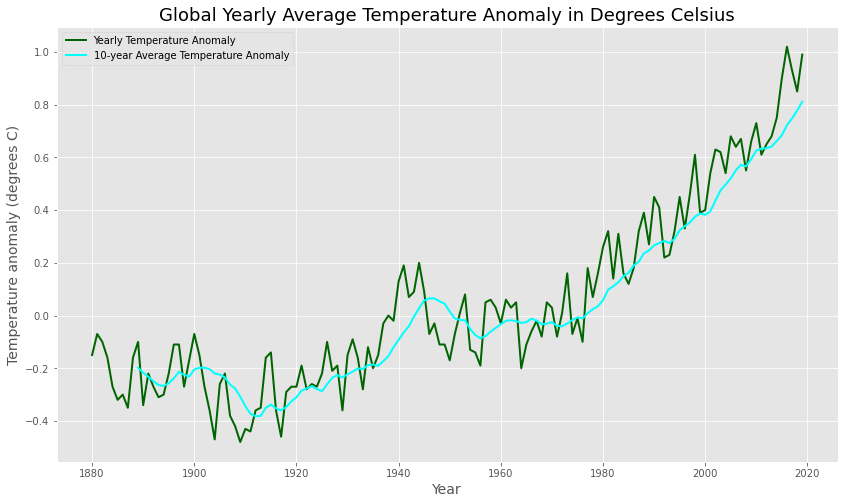

In [7]:
roll_anom = zonal_changes.rolling(window=10).mean()

# Plot the global yearly average temperature change 
fig = plt.figure(figsize=(14,8))
plt.plot(zonal_changes.Glob, color='darkgreen', lw=2, label='Yearly Temperature Anomaly')
plt.plot(roll_anom.Glob, color='cyan', lw=2, label='10-year Average Temperature Anomaly')
plt.ylabel('Temperature anomaly (degrees C)', fontsize=14)
plt.xlabel('Year', fontsize=14)
plt.title('Global Yearly Average Temperature Anomaly in Degrees Celsius', fontsize=18)
plt.legend()
plt.show()

**Analysis:** The global average temperature anomaly displays a steady increasing trend beginning around 1980. The global average temperature anomaly in January of 1980 and 2018 (end of the dataset) is 0.26 C and 0.85 C, respectively. Therefore, the global average temperature anomaly increased by 0.0155 C per year over that span of 38 years. However, the temperature anomaly over the past 18 years (2000 to 2018) has been increasing at a rate of 0.0256 C per year, indicating that the global average temperature anomaly is increasing at a non-linear rate.

## Claim 2: What  is "temperature anomaly"? It seems like it is a convienent transformation of the data to support global warming research.

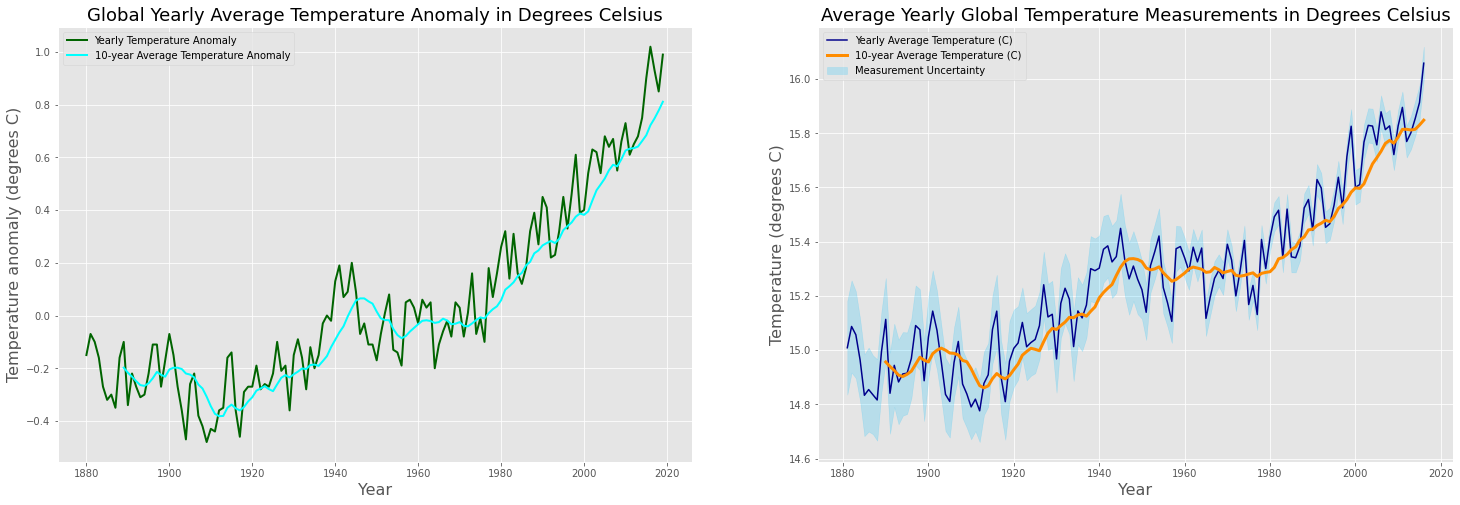

In [10]:
global_temps = pd.read_csv('Data/GlobalTemperatures.csv', index_col='dt', parse_dates=True)
global_temps.dropna(inplace=True)
global_temps.index.freq = 'MS'

global_temps_yr = global_temps.resample('A').mean()

temp_err = global_temps_yr.LandAndOceanAverageTemperatureUncertainty.loc['1880':]
temp_line = global_temps_yr['LandAndOceanAverageTemperature']
roll_temp = global_temps_yr.loc['1880':].rolling(window=10).mean()


fig, ax = plt.subplots(1,2, figsize=(25,8))
ax[0].plot(zonal_changes.Glob, color='darkgreen', lw=2, label='Yearly Temperature Anomaly')
ax[0].plot(roll_anom.Glob, color='cyan', lw=2, label='10-year Average Temperature Anomaly')
ax[0].set_ylabel('Temperature anomaly (degrees C)', fontsize=16)
ax[0].set_xlabel('Year', fontsize=16)
ax[0].set_title('Global Yearly Average Temperature Anomaly in Degrees Celsius', fontsize=18)
ax[0].legend()

ax[1].plot(global_temps_yr['LandAndOceanAverageTemperature'].loc['1880':], color='darkblue', 
           label='Yearly Average Temperature (C)')
ax[1].plot(roll_temp.LandAndOceanAverageTemperature, color='darkorange', lw=3, 
           label='10-year Average Temperature (C)')
ax[1].fill_between(temp_line.index, temp_line - temp_err, temp_line + temp_err,
                 color='deepskyblue', alpha=0.2, label='Measurement Uncertainty')
ax[1].set_xlabel('Year', fontsize=16)
ax[1].set_ylabel('Temperature (degrees C)', fontsize=16)
ax[1].set_title('Average Yearly Global Temperature Measurements in Degrees Celsius', fontsize=18)
ax[1].legend()
#plt.tight_layout()
plt.show()

**Analysis:** The graph on the right displays the actual global yearly average temperature measurements in degrees celsius. The upward trend in the temperature anomaly graph (left) beginning around 1980 is seen in the yearly average measurements at the same time. Thus, temperature anomaly is not an arbitrary transformation of temperature data.

Source: https://www.kaggle.com/berkeleyearth/climate-change-earth-surface-temperature-data

In [13]:
print(global_temps_yr['LandAndOceanAverageTemperature'].loc['1880':])
#print(roll_temp.LandAndOceanAverageTemperature)

dt
1880-12-31    15.008667
1881-12-31    15.087167
1882-12-31    15.056583
1883-12-31    14.963250
1884-12-31    14.833250
                ...    
2011-12-31    15.769500
2012-12-31    15.802333
2013-12-31    15.854417
2014-12-31    15.913000
2015-12-31    16.058583
Freq: A-DEC, Name: LandAndOceanAverageTemperature, Length: 136, dtype: float64


In [14]:
global_avg = pd.DataFrame()
global_avg["Date"] = list(roll_temp.index)
global_avg["Yearly"] = list(global_temps_yr['LandAndOceanAverageTemperature'].loc['1880':])
global_avg["10 Year Average"] = list(roll_temp.LandAndOceanAverageTemperature)
global_avg.to_csv("Global_avg.csv")


## Claim 3: You've only reported yearly average temperatures. What if there was just one really hot month each year that is giving a false sense of global warming?

In [9]:
# Import global average monthly temperature anomoly data
temp_changes = pd.read_csv('global/monthly_temp_index.csv', header=1)
print(temp_changes.shape)
temp_changes.head()

(140, 19)


Year   Jan   Feb   Mar   Apr   May   Jun   Jul   Aug   Sep   Oct   Nov  \
0  1880 -0.18 -0.25 -0.09 -0.17  -.11  -.21  -.19  -.10  -.15  -.23  -.22   
1  1881 -0.19 -0.14  0.04  0.05   .06  -.19   .00  -.04  -.16  -.22  -.18   
2  1882  0.17  0.15  0.05 -0.17  -.15  -.23  -.16  -.07  -.14  -.24  -.16   
3  1883 -0.28 -0.37 -0.13 -0.19  -.17  -.08  -.06  -.13  -.21  -.11  -.23   
4  1884 -0.13 -0.09 -0.37 -0.40  -.35  -.35  -.33  -.28  -.28  -.26  -.33   

    Dec   J-D   D-N   DJF   MAM   JJA   SON  
0  -.17  -.17   ***   ***  -.12  -.17  -.20  
1  -.07  -.09  -.09  -.17   .05  -.07  -.19  
2  -.35  -.11  -.08   .08  -.09  -.15  -.18  
3  -.12  -.17  -.19  -.34  -.16  -.09  -.18  
4  -.31  -.29  -.27  -.11  -.37  -.32  -.29

In [10]:
##### Format data for visualization

# Isolate the columns pertaining to individual months
hm_temp_changes = temp_changes[['Year', 'Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']]

# Set the Year column to datetime format and set as index of the dataframe
hm_temp_changes.Year = pd.to_datetime(hm_temp_changes.Year, format='%Y')
hm_temp_changes.set_index('Year', inplace=True)

hm_temp_changes.head()

Jan   Feb   Mar   Apr   May   Jun   Jul   Aug   Sep   Oct   Nov  \
Year                                                                           
1880-01-01 -0.18 -0.25 -0.09 -0.17  -.11  -.21  -.19  -.10  -.15  -.23  -.22   
1881-01-01 -0.19 -0.14  0.04  0.05   .06  -.19   .00  -.04  -.16  -.22  -.18   
1882-01-01  0.17  0.15  0.05 -0.17  -.15  -.23  -.16  -.07  -.14  -.24  -.16   
1883-01-01 -0.28 -0.37 -0.13 -0.19  -.17  -.08  -.06  -.13  -.21  -.11  -.23   
1884-01-01 -0.13 -0.09 -0.37 -0.40  -.35  -.35  -.33  -.28  -.28  -.26  -.33   

             Dec  
Year              
1880-01-01  -.17  
1881-01-01  -.07  
1882-01-01  -.35  
1883-01-01  -.12  
1884-01-01  -.31

In [11]:
# This dataset is managed and updated monthly by NASA, thus '***' is used as a placeholder value for data that had
# not been updated at the time when this set was downloaded
hm_temp_changes = hm_temp_changes.loc[(hm_temp_changes.May != '***') & (hm_temp_changes.Jun != '***') & 
                                     (hm_temp_changes.Jul != '***') & (hm_temp_changes.Aug != '***') & 
                                     (hm_temp_changes.Sep != '***') & (hm_temp_changes.Oct != '***') & 
                                     (hm_temp_changes.Nov != '***') & (hm_temp_changes.Dec != '***')]

# Convert all column data types to float
hm_temp_changes = hm_temp_changes.astype('float')

print(hm_temp_changes.shape)
hm_temp_changes.head()

(139, 12)


Jan   Feb   Mar   Apr   May   Jun   Jul   Aug   Sep   Oct   Nov  \
Year                                                                           
1880-01-01 -0.18 -0.25 -0.09 -0.17 -0.11 -0.21 -0.19 -0.10 -0.15 -0.23 -0.22   
1881-01-01 -0.19 -0.14  0.04  0.05  0.06 -0.19  0.00 -0.04 -0.16 -0.22 -0.18   
1882-01-01  0.17  0.15  0.05 -0.17 -0.15 -0.23 -0.16 -0.07 -0.14 -0.24 -0.16   
1883-01-01 -0.28 -0.37 -0.13 -0.19 -0.17 -0.08 -0.06 -0.13 -0.21 -0.11 -0.23   
1884-01-01 -0.13 -0.09 -0.37 -0.40 -0.35 -0.35 -0.33 -0.28 -0.28 -0.26 -0.33   

             Dec  
Year              
1880-01-01 -0.17  
1881-01-01 -0.07  
1882-01-01 -0.35  
1883-01-01 -0.12  
1884-01-01 -0.31

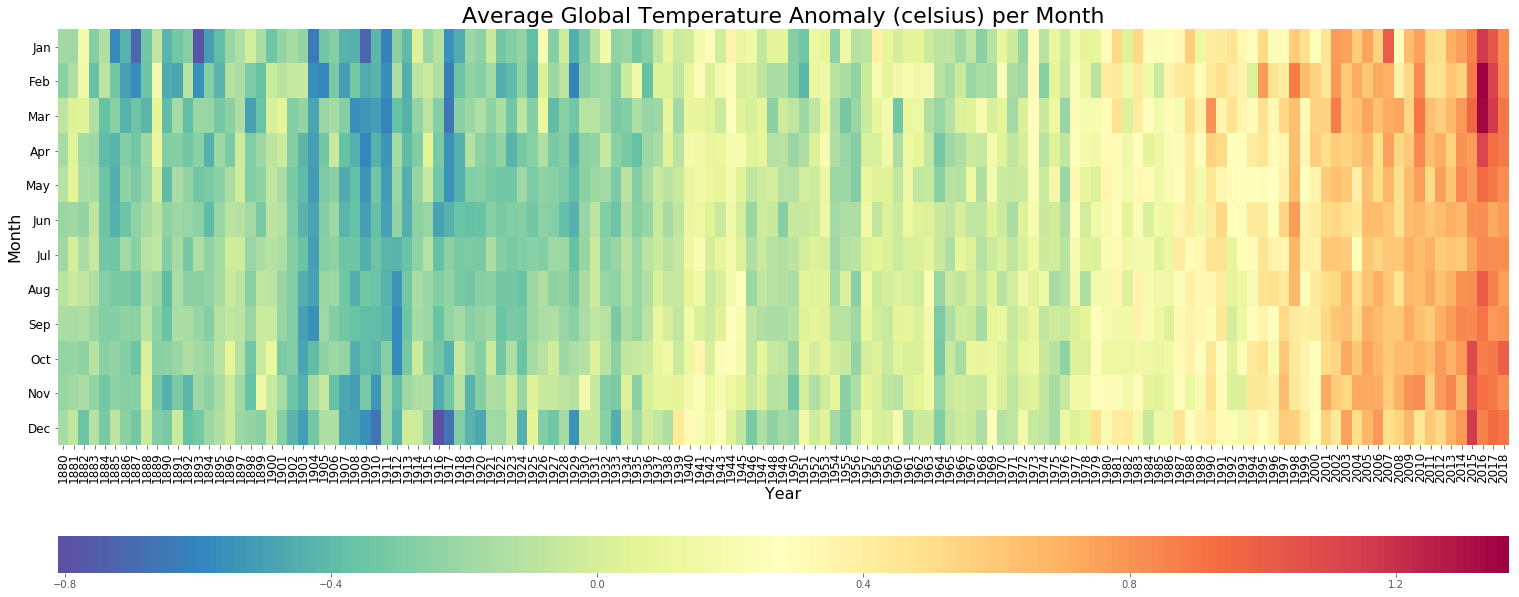

In [12]:
# Set parameters for displaying the heatmap and its scale bar
grid_kws = {"height_ratios": (.9, .08), "hspace": .4}
f, (ax, cbar_ax) = plt.subplots(2, figsize=(26,10), gridspec_kw=grid_kws)
ax = sns.heatmap(hm_temp_changes.T, 
                 ax=ax, 
                 xticklabels=hm_temp_changes.index.year, 
                 cmap='Spectral_r',
                 cbar_ax=cbar_ax,
                 cbar_kws={"orientation": "horizontal"})
ax.set_title('Average Global Temperature Anomaly (celsius) per Month', fontsize=22)
ax.set_xlabel('Year',fontsize=16, color='black')
ax.set_xticklabels(hm_temp_changes.index.year, fontsize=12, color='black')
ax.set_ylabel('Month', fontsize=16, color='black')
ax.set_yticklabels(hm_temp_changes.columns, fontsize=12, color='black', rotation=0)
plt.show()

**Analysis:** Over the 138 years in which this dataset spans, the global average monthly temperature anomalies appear to be increasing. Additionally, the increase in monthly temperature anomalies seems to be relatively consistent within each year. If the claim that _"one really hot month each year is skewing the yearly average temperature measurements"_ was true, then the figure above would be a fairly uniform yellowish-green color (corresponding to a temperature anomaly of 0) with one dark red square (indicating a large positive temperature anomaly) per year. That pattern is not seen in this figure and the general trend of the color gradation indicates the average global temperature is increasing.
<br>

## Claim 4: What if the sun is radiating more heat and _THAT_ is actually what is causing the increase in global temperatures?


### Data source: http://www2.mps.mpg.de/projects/sun-climate/data.html



In [13]:
# Read in the multiple data files and combine
tsi1 = pd.read_excel('tsi_data/tsi_0_10.xls')
tsi1.julian_day = tsi1.julian_day.map(julian_to_datetime)

tsi2 = pd.read_excel('tsi_data/tsi_10_20.xlsx')
tsi2.columns = ['julian_day', 'tsi_W_m2']
tsi2.julian_day = tsi2.julian_day.map(julian_to_datetime)

tsi3 = pd.read_excel('tsi_data/tsi_20_30.xlsx')
tsi3.julian_day = tsi3.julian_day.map(julian_to_datetime)

tsi4 = pd.read_excel('tsi_data/tsi_30_40.xlsx')
tsi4.julian_day = tsi4.julian_day.map(julian_to_datetime)

tsi5 = pd.read_excel('tsi_data/tsi_40_50.xlsx')
tsi5.julian_day = tsi5.julian_day.map(julian_to_datetime)

tsi6 = pd.read_excel('tsi_data/tsi_50_60.xlsx')
tsi6.julian_day = tsi6.julian_day.map(julian_to_datetime)

tsi7 = pd.read_excel('tsi_data/tsi_60_70.xlsx')
tsi7.julian_day = tsi7.julian_day.map(julian_to_datetime)

tsi8 = pd.read_excel('tsi_data/tsi_70_80.xlsx')
tsi8.julian_day = tsi8.julian_day.map(julian_to_datetime)

tsi9 = pd.read_excel('tsi_data/tsi_80_90.xlsx')
tsi9.julian_day = tsi9.julian_day.map(julian_to_datetime)

tsi10 = pd.read_excel('tsi_data/tsi_90_100.xlsx')
tsi10.julian_day = tsi10.julian_day.map(julian_to_datetime)

tsi11 = pd.read_excel('tsi_data/tsi_100_112.xlsx')
tsi11.julian_day = tsi11.julian_day.map(julian_to_datetime)

# Combine all of the TSI data files into a single df, format column names, and set datetime index
tsi_all = tsi1.append([tsi2,tsi3,tsi4,tsi5,tsi6,tsi7,tsi8,tsi9,tsi10,tsi11])
tsi_all.columns = ['date', 'tsi_W_m2']
tsi_all.set_index('date', inplace=True)
tsi_all.index.freq = 'D'

# Resample data to reflected yearly average TSI
tsi_yearly = tsi_all.resample('AS-JAN').mean()
tsi_yearly.head()

tsi_W_m2
date                   
1700-01-01  1360.274753
1701-01-01  1360.280258
1702-01-01  1360.280833
1703-01-01  1360.322605
1704-01-01  1360.335802

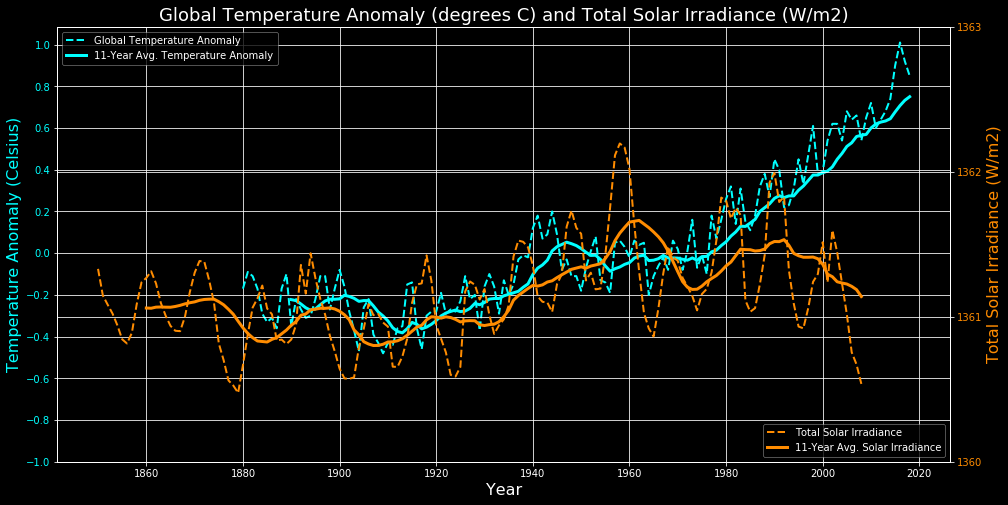

In [18]:
# Calculate the 11-year rolling mean for global temperature anomaly and total solar irradiance
zonal_roll = zonal_changes.Glob.rolling(window=11).mean()
roll_tsi = tsi_yearly.loc['1850':].rolling(window=11).mean()

plt.style.use('dark_background')

# Plot the global temperature anomaly with the total solar irradiance data
fig, ax1 = plt.subplots(figsize=(16,8))

ax1.plot(zonal_changes['Glob'], color='cyan', ls="--", lw=2, label='Global Temperature Anomaly')
ax1.plot(zonal_roll, color='cyan', lw=3, label='11-Year Avg. Temperature Anomaly')
ax1.set_yticks([-1, -0.8, -0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])
ax1.set_ylabel('Temperature Anomaly (Celsius)', color='cyan', fontsize=16)
ax1.set_xlabel('Year', fontsize=16, color='white')
ax1.tick_params(axis='y', labelcolor='cyan')
ax1.legend()
#ax1.set_facecolor('black')

# instantiate a second axis for TSI scale that shares the same x-axis
ax2 = ax1.twinx()  

ax2.plot(tsi_yearly.loc['1850':], color='darkorange', ls="--", lw=2, label='Total Solar Irradiance')
ax2.plot(roll_tsi, color='darkorange', lw=3, label='11-Year Avg. Solar Irradiance')
ax2.set_yticks([1360, 1361, 1362, 1363])
ax2.set_ylabel('Total Solar Irradiance (W/m2)', color='darkorange', fontsize=16)
ax2.tick_params(axis='y', labelcolor='darkorange')
ax2.legend(loc=4)

plt.title('Global Temperature Anomaly (degrees C) and Total Solar Irradiance (W/m2)', fontsize=18)
plt.show()

**Analysis:** The graph displays the global yearly temperature anomalies (green) and the total solar irradiance (orange) between 1850 and 2018. While the flucuations make it a little difficult to analyze, there does not appear to be strong evidence suggesting the sun is radiating more heat as the total solar irradiance values fluctuate within a small range (2 W/m2) and do not display an obvious trend. Additionally, there is a spike in global yearly temperature anomaly around 1945 that **preceeds** a spike in total solar irradiance. If the claim that _"the sun is radiating more heat and this increased irradiance is what is causing the rise in global temperatures"_ was true, then it would be expected for the graph to show the opposite, i.e a spike in total solar irradiance preceeding a spike in global temperature anomalies.


In [14]:
# Combine the two series into a single dataframe. Global temperature anomaly has to be column 0 and total solar
# irradiance has to be column 1 as the test is analyzing if the time series in column 1 granger-causes the time 
# series in column 0

temp_and_tsi = zonal_changes.join(tsi_yearly).dropna()
temp_and_tsi = temp_and_tsi[['Glob', 'tsi_W_m2']]
temp_and_tsi.head()

Glob     tsi_W_m2
Year                         
1880-01-01 -0.17  1360.667766
1881-01-01 -0.09  1360.878758
1882-01-01 -0.11  1361.063651
1883-01-01 -0.17  1361.127404
1884-01-01 -0.29  1361.215902

In [15]:
### Determine if global temperature anomaly data is stationary

# Raw
print('Raw Global Temperature Anomaly values:\n')
dickey_fuller_test(temp_and_tsi.Glob) # Nope. p-value of 0.98
print('\n')
# One lag difference
temp_diff1 = temp_and_tsi.Glob.diff(periods=1).dropna()
print('One lag differenced global temperature anomaly values:\n')
dickey_fuller_test(temp_diff1) # Yes! p-value of basically 0 with 4 lags used

Raw Global Temperature Anomaly values:

Results of Dickey-Fuller Test:
Test Statistic                   0.431053
p-value                          0.982620
#Lags Used                       5.000000
Number of Observations Used    123.000000
Critical Value (1%)             -3.484667
Critical Value (5%)             -2.885340
Critical Value (10%)            -2.579463
dtype: float64


One lag differenced global temperature anomaly values:

Results of Dickey-Fuller Test:
Test Statistic                -7.369006e+00
p-value                        9.075668e-11
#Lags Used                     4.000000e+00
Number of Observations Used    1.230000e+02
Critical Value (1%)           -3.484667e+00
Critical Value (5%)           -2.885340e+00
Critical Value (10%)          -2.579463e+00
dtype: float64


In [16]:
### Determine if total solar irradiance data is stationary

# Raw
print('Raw total solar irradiance values:\n')
dickey_fuller_test(temp_and_tsi.tsi_W_m2) # Nope. p-value of 0.41
print('\n')
# One lag difference
tsi_diff1 = temp_and_tsi.tsi_W_m2.diff(periods=1).dropna()
print('One lag differenced total solar irradiance values:\n')
dickey_fuller_test(tsi_diff1) # Yes! p-value of basically 0 with 5 lags used

Raw total solar irradiance values:

Results of Dickey-Fuller Test:
Test Statistic                  -1.748256
p-value                          0.406436
#Lags Used                       6.000000
Number of Observations Used    122.000000
Critical Value (1%)             -3.485122
Critical Value (5%)             -2.885538
Critical Value (10%)            -2.579569
dtype: float64


One lag differenced total solar irradiance values:

Results of Dickey-Fuller Test:
Test Statistic                -9.810328e+00
p-value                        5.679623e-17
#Lags Used                     5.000000e+00
Number of Observations Used    1.220000e+02
Critical Value (1%)           -3.485122e+00
Critical Value (5%)           -2.885538e+00
Critical Value (10%)          -2.579569e+00
dtype: float64


In [17]:
# Based on the results from the Augmented Dickey-Fuller Test, both time series are stationary with a difference order
# of 1. The differenced time series will be used with the VAR model to select the lag order for the Granger Causality
# Test


# Difference the time series with a period of 1 based on the Dickey-Fuller Test results
temp_and_tsi_diff = temp_and_tsi.diff(periods=1).dropna()

# Instantiate the VAR model for order selection
order_model = VAR(temp_and_tsi_diff)

# Loop through order values and record the AIC value
for p_order in list(range(1,12)):
    results = order_model.fit(p_order)
    print('Order:', p_order, ' AIC:', results.aic)


Order: 1  AIC: -7.812497302382799
Order: 2  AIC: -7.834154499694101
Order: 3  AIC: -7.871688512965335
Order: 4  AIC: -7.971156201399412
Order: 5  AIC: -8.23271209410016
Order: 6  AIC: -8.257100722213169
Order: 7  AIC: -8.218024537743295
Order: 8  AIC: -8.18208748604225
Order: 9  AIC: -8.101220674799007
Order: 10  AIC: -8.089016779367473
Order: 11  AIC: -8.044171748689243


In [18]:
# The VAR model with the lowest AIC had an order of 6. This value will be used as the max value for the Granger
# Causality Test

#granger_temp_tsi = grangercausalitytests(temp_and_tsi_diff, maxlag=6)
display_granger_results(temp_and_tsi_diff, 6)

No significant results found in 6 lags


**Analysis:** As there were no significant results from the Granger Causality Test, there is no evidence to reject the null hypothesis. Thus, there is no eveidence to suggest that total solar irradiance aids in the prediction of (i.e. has a causal effect on) temperature anomaly. It is important to note that while significant increases in total solar irradiance will absolutely affect global temperatures, the findings from the Granger Causality Test suggest that the flucuations present in the total solar irradiation data are not large enough to influence the trends present in the global temperature anomaly data.

### Conclusion for Analysis of Global Temperature Changes

The analysis from the project suggests that global temperatures are rising steadily since 1980. The measure of "global temperature anomaly" bases changes on measurement deviations from the data collected between 1950 and 1980 and reflects the trends observed in actual temperature measurements. Lastly, theory that global temperatures are rising due to increased solar output was not supported as the data in the TSI time series did not granger-cause the data in the global temperature anomaly time series when analyzed out to 6 lags.



# Part 2: Effects of Rising Temperatures on Ice Extent


### Source:
### - Northern hemisphere: ftp://sidads.colorado.edu/DATASETS/NOAA/G02135/north/daily/data/
### - Southern hemisphere: ftp://sidads.colorado.edu/DATASETS/NOAA/G02135/south/daily/data/


In [15]:
icecaps_north = pd.read_csv('Data/seaice_north.csv')
icecaps_north["hemisphere"]="north"
icecaps_south = pd.read_csv('Data/seaice_south.csv')
icecaps_south["hemisphere"]="south"
temp = [ icecaps_north,icecaps_south]
icecaps = pd.concat(temp)
#icecaps = icecaps.drop(0)
#icecaps.reset_index(drop=True)
icecaps.head()

Year   Month   Day       Extent      Missing  \
0  1978      10    26       10.231          0.0   
1  1978      10    28       10.420          0.0   
2  1978      10    30       10.557          0.0   
3  1978      11     1       10.670          0.0   
4  1978      11     3       10.777          0.0   

                                         Source Data hemisphere  
0   ['/ecs/DP1/PM/NSIDC-0051.001/1978.10.26/nt_19...      north  
1   ['/ecs/DP1/PM/NSIDC-0051.001/1978.10.28/nt_19...      north  
2   ['/ecs/DP1/PM/NSIDC-0051.001/1978.10.30/nt_19...      north  
3   ['/ecs/DP1/PM/NSIDC-0051.001/1978.11.01/nt_19...      north  
4   ['/ecs/DP1/PM/NSIDC-0051.001/1978.11.03/nt_19...      north

In [16]:
# Drop unnecessary column
icecaps = icecaps.drop([' Source Data'], axis=1)

# Rename the columns to a more friendly format
icecaps.columns = ['year', 'month', 'day', 'extent', 'missing', 'hemisphere']

# Combine the year, month, day columns to datetime format and set as index of the df
icecaps['datetime'] = pd.to_datetime(dict(year=icecaps.year, month=icecaps.month, day=icecaps.day))
icecaps.set_index('datetime', inplace=True)

# Drop the redundant columns
icecaps.drop(['year','month','day'], axis=1, inplace=True)

icecaps.head()

extent  missing hemisphere
datetime                              
1978-10-26  10.231      0.0      north
1978-10-28  10.420      0.0      north
1978-10-30  10.557      0.0      north
1978-11-01  10.670      0.0      north
1978-11-03  10.777      0.0      north

In [17]:
# Split the df into northern hemisphere ice and southern hemisphere ice
north_ice = icecaps.loc[icecaps.hemisphere == 'north']
print(north_ice.shape)
south_ice = icecaps.loc[icecaps.hemisphere == 'south']
print(south_ice.shape)

(13702, 3)
(13702, 3)


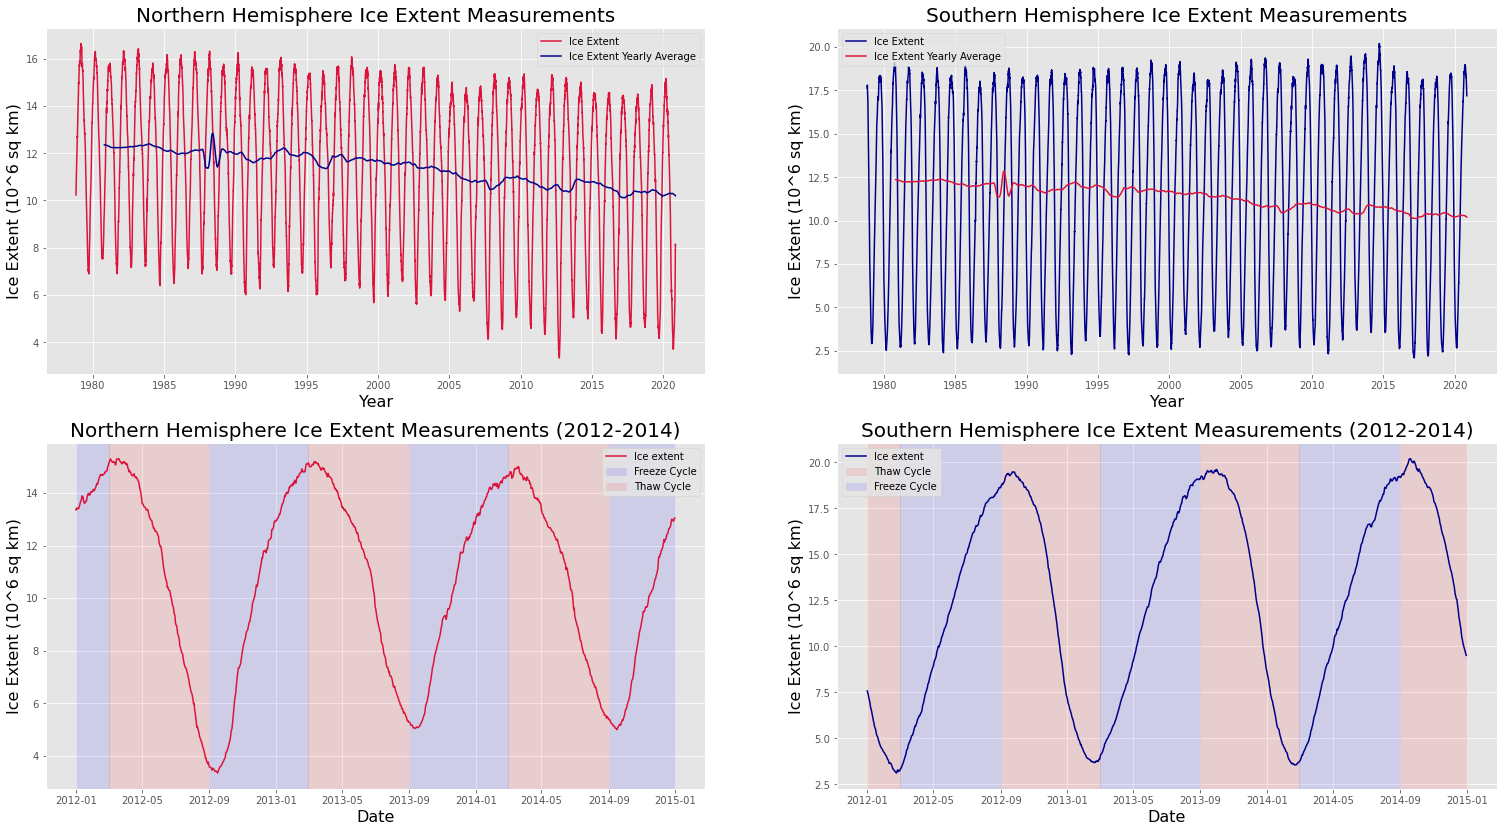

In [18]:
plt.style.use('ggplot')

# Create the subplots figure
fig, ax =plt.subplots(2,2, figsize=(26,14))

# Calculate the rolling mean for the northern hemisphere ice extent
rollingN = north_ice.extent.rolling(window=365).mean()

# Plot northern hemisphere ice extent with its rolling mean
ax[0,0].plot(north_ice.extent, color='crimson', label='Ice Extent')
ax[0,0].plot(rollingN, color='darkblue', label='Ice Extent Yearly Average')
ax[0,0].set_title('Northern Hemisphere Ice Extent Measurements', fontsize=20)
ax[0,0].set_xlabel('Year', fontsize=16, color='black')
ax[0,0].set_ylabel('Ice Extent (10^6 sq km)', fontsize=16, color='black')
ax[0,0].legend()

# Plot the 2-year period of northern hemisphere ice extent to display seasonality
ax[1,0].plot(north_ice.extent.loc['2012':'2014'], color='crimson', label='Ice extent')
ax[1,0].set_title('Northern Hemisphere Ice Extent Measurements (2012-2014)', fontsize=20)
ax[1,0].set_xlabel('Date', fontsize=16, color='black')
ax[1,0].set_ylabel('Ice Extent (10^6 sq km)', fontsize=16, color='black')
ax[1,0].axvspan('2012-01', '2012-03', color='blue', alpha=0.1, label='Freeze Cycle')
ax[1,0].axvspan('2012-03', '2012-09', color='red', alpha=0.1, label='Thaw Cycle')
ax[1,0].axvspan('2012-09', '2013-03', color='blue', alpha=0.1)
ax[1,0].axvspan('2013-03', '2013-09', color='red', alpha=0.1)
ax[1,0].axvspan('2013-09', '2014-03', color='blue', alpha=0.1)
ax[1,0].axvspan('2014-03', '2014-09', color='red', alpha=0.1)
ax[1,0].axvspan('2014-09', '2015-01', color='blue', alpha=0.1)
ax[1,0].legend()

# Calculate the rolling mean for the ice extent of the southern hemisphere
rollingS = south_ice.extent.rolling(window=365).mean()

# Plot southern hemisphere ice extent with its rolling mean
ax[0,1].plot(south_ice.extent, color='darkblue', label='Ice Extent')
ax[0,1].plot(rollingN, color='crimson', label='Ice Extent Yearly Average')
ax[0,1].set_title('Southern Hemisphere Ice Extent Measurements', fontsize=20)
ax[0,1].set_xlabel('Year', fontsize=16, color='black')
ax[0,1].set_ylabel('Ice Extent (10^6 sq km)', fontsize=16, color='black')
ax[0,1].legend()

# Plot the 2-year period of southern hemisphere ice extent to display seasonality
ax[1,1].plot(south_ice.extent.loc['2012':'2014'], color='darkblue', label='Ice extent')
ax[1,1].set_title('Southern Hemisphere Ice Extent Measurements (2012-2014)', fontsize=20)
ax[1,1].axvspan('2012-01', '2012-03', color='red', alpha=0.1, label='Thaw Cycle')
ax[1,1].axvspan('2012-03', '2012-09', color='blue', alpha=0.1, label='Freeze Cycle')
ax[1,1].axvspan('2012-09', '2013-03', color='red', alpha=0.1)
ax[1,1].axvspan('2013-03', '2013-09', color='blue', alpha=0.1)
ax[1,1].axvspan('2013-09', '2014-03', color='red', alpha=0.1)
ax[1,1].axvspan('2014-03', '2014-09', color='blue', alpha=0.1)
ax[1,1].axvspan('2014-09', '2015-01', color='red', alpha=0.1)
ax[1,1].set_xlabel('Date', fontsize=16, color='black')
ax[1,1].set_ylabel('Ice Extent (10^6 sq km)', fontsize=16, color='black')
ax[1,1].legend()

plt.show()

**Analysis:** The fluctuations in ice extent measurements correspond to seasonal freeze-thaw cycles. Additionally, these cycles are shifted by six months between the two hemispheres due to each hemisphere's opposite seasonal pattern. While the range of freeze-thaw extent fluctuation doesn't appear to be changing dramatically, the yearly average of the ice extent measurements demonstrates a general downward trend. Furthermore, the rate of ice loss is occuring faster in the northern hemisphere (-0.048 million sq km per year) than it is in the southern hemisphere (-0.015 million sq km per year). Because the freeze-thaw cycles are shifted by six months between the hemispheres, when the northern ice is melting the southern ice should be freezing, resulting in a net-zero change in global ice extent. However, since both hemispheres are experiencing a loss in total ice extent each year, the thaw in one hemisphere is not being compensated by an equal freeze in the other hemisphere, suggesting that either the freeze cycle in each hemisphere is becoming shorter (due to climate change) or because average gloabl temperatures are rising and inhibiting freezing. 

A negative value for the rate of change for ice extent should equate to a rise in global sea levels. This relationship will be explored in this project shortly. But first, the relationship between ice extent and global temperature anomalies will be examined to determine if rising temperatures are affecting ice extent. This relationship will be explored with the Granger Causality Test utilizing the same method as with the analysis of total solar irradiance and temperature anomalies.

In [19]:
# The frequency is every other day for data collected between 1978 and 1987, but switches to daily data in 1988.
# Isolate data for each hemisphere collected after 1987 and resample as the same frequency of temperature anomaly.

ice_north = north_ice.loc['1988':].resample('AS-JAN').mean()
ice_south = south_ice.loc['1988':].resample('AS-JAN').mean()

In [20]:
# Combine the northern hemisphere ice extent dataset with the global temperature anomaly dataset
ice_north_temp = ice_north.join(zonal_changes).dropna()
ice_north_temp = ice_north_temp[['extent', 'Glob']]
ice_north_temp.head()

extent  Glob
datetime                   
1988-01-01  12.093169  0.39
1989-01-01  11.966855  0.27
1990-01-01  11.693841  0.45
1991-01-01  11.749258  0.41
1992-01-01  12.110481  0.22

In [21]:
# Combine the southern hemisphere ice extent dataset with the global temperature anomaly dataset
ice_south_temp = ice_south.join(zonal_changes).dropna()
ice_south_temp = ice_south_temp[['extent', 'Glob']]
ice_south_temp.head()

extent  Glob
datetime                   
1988-01-01  11.685189  0.39
1989-01-01  11.425679  0.27
1990-01-01  11.409595  0.45
1991-01-01  11.544874  0.41
1992-01-01  11.398617  0.22

In [25]:
# Check for stationarity in the northern hemisphere ice extent measurements

# Raw
print('Raw Northern Hemisphere ice extent values:\n')
dickey_fuller_test(ice_north_temp.extent) # Nope. p-value of 0.98
print('\n')
# One lag difference
ice_diff1 = ice_north_temp.extent.diff(periods=1).dropna()
print('One lag differenced Northern Hemisphere ice extent values:\n')
dickey_fuller_test(ice_diff1) # Still no. p-value of 0.3
print('\n')
# Two lag difference
ice_diff2 = ice_north_temp.extent.diff(periods=2).dropna()
print('Two lag differenced Northern Hemisphere ice extent values:\n')
dickey_fuller_test(ice_diff2) # Still no. p-value of 0.25
print('\n')
# Three lag difference
ice_diff3 = ice_north_temp.extent.diff(periods=3).dropna()
print('Three lag differenced Northern Hemisphere ice extent values:\n')
dickey_fuller_test(ice_diff3) # Still no. p-value of 0.5
print('\n')
# Four lag difference
ice_diff4 = ice_north_temp.extent.diff(periods=4).dropna()
print('Four lag differenced Northern Hemisphere ice extent values:\n')
dickey_fuller_test(ice_diff4) # Still no. p-value of 0.1
print('\n')
# Five lag difference
ice_diff5 = ice_north_temp.extent.diff(periods=5).dropna()
print('Five lag differenced Northern Hemisphere ice extent values:\n')
dickey_fuller_test(ice_diff5) # Still no. p-value of 0.1
print('\n')
# Six lag difference
ice_diff6 = ice_north_temp.extent.diff(periods=6).dropna()
print('Six lag differenced Northern Hemisphere ice extent values:\n')
dickey_fuller_test(ice_diff6) # Still no. p-value of 0.09
print('\n')
# Seven lag difference
ice_diff7 = ice_north_temp.extent.diff(periods=7).dropna()
print('Seven lag differenced Northern Hemisphere ice extent values:\n')
dickey_fuller_test(ice_diff7) # Still no. p-value of 0.06
print('\n')
# Eight lag difference
ice_diff8 = ice_north_temp.extent.diff(periods=8).dropna()
print('Eight lag differenced Northern Hemisphere ice extent values:\n')
dickey_fuller_test(ice_diff8) # Finally! p-value of 0.049 using 7 lags

Raw Northern Hemisphere ice extent values:

Results of Dickey-Fuller Test:
Test Statistic                 -0.255348
p-value                         0.931595
#Lags Used                      5.000000
Number of Observations Used    25.000000
Critical Value (1%)            -3.723863
Critical Value (5%)            -2.986489
Critical Value (10%)           -2.632800
dtype: float64


One lag differenced Northern Hemisphere ice extent values:

Results of Dickey-Fuller Test:
Test Statistic                 -1.961377
p-value                         0.303760
#Lags Used                      4.000000
Number of Observations Used    25.000000
Critical Value (1%)            -3.723863
Critical Value (5%)            -2.986489
Critical Value (10%)           -2.632800
dtype: float64


Two lag differenced Northern Hemisphere ice extent values:

Results of Dickey-Fuller Test:
Test Statistic                 -2.092281
p-value                         0.247630
#Lags Used                      7.000000
Number of Ob

In [26]:
# Based on the results from the Augmented Dickey-Fuller Test, the northern hemisphere ice extent time series is 
# stationary with a difference order of 8. The differenced time series will be used with the VAR model to select 
# the lag order for the Granger Causality Test.

# Difference the time series based on the results of the Dickey-Fuller Test
ice_north_temp_diff = ice_north_temp.diff(periods=8).dropna()

# Instantiate a VAR model to select order
order_model = VAR(ice_north_temp_diff)

# Loop through order values and record AIC values
for p_order in list(range(1,12)):
    results = order_model.fit(p_order)
    print('Order:', p_order, ' AIC:', results.aic)
    

Order: 1  AIC: -6.21094665797399
Order: 2  AIC: -6.199066884704018
Order: 3  AIC: -5.782035425441197
Order: 4  AIC: -6.660472454678325
Order: 5  AIC: -7.828066792029963
Order: 6  AIC: -8.305333025090842
Order: 7  AIC: -45.85706892331748
Order: 8  AIC: -135.18930398965384
Order: 9  AIC: -133.2859586735166
Order: 10  AIC: -131.5945932089944
Order: 11  AIC: -128.90378879248968


In [27]:
# The VAR model with the lowest AIC had an order of 8. However, based on the number of observations in the time
# series, the maximum lag that the test can perform is 7

#granger_ice_north_temp = grangercausalitytests(ice_north_temp_diff, maxlag=7)
display_granger_results(ice_north_temp_diff, 7)

SIGNIFICANT RESULTS FOUND BY LAG -- 4 

P-Values:

Sum of Squares of the Residuals F-Test: 0.13685395303412387
Sum of Squares of the Residuals Chi Squared Test: 0.0018911878254199094
Likelihood-Ratio Test: 0.01614289319823196
Joint Model Parameters F-Test: 0.13685395303412404


**Analysis:** While the proposed method for the Granger Causality Test suggested analyzing the data out to 8 lag, the number of observations in the series limited the test to 7 lags. However, significant findings were established by the 4th lag. Because significant results at any lag examined during the test indicates that the independent time series (in this example, global temperature anomaly) granger-causes the dependent time series (ice extent in the northern hemisphere), these results suggest the changes in global temperature anomaly are affecting the ice extent in the northern hemisphere.

In [28]:
# Check for stationarity in the southern hemisphere ice extent measurements

# Raw
print('Raw Southern Hemisphere ice extent values:\n')
dickey_fuller_test(ice_south_temp.extent) # Nope. p-value of 0.19
print('\n')
# One lag difference
ice_diff1 = ice_south_temp.extent.diff(periods=1).dropna()
print('One lag differenced Southern Hemisphere ice extent values:\n')
dickey_fuller_test(ice_diff1) # Still no. p-value of 0.36
print('\n')
# Two lag difference
ice_diff2 = ice_south_temp.extent.diff(periods=2).dropna()
print('Two lag differenced Southern Hemisphere ice extent values:\n')
dickey_fuller_test(ice_diff2) # Yes! p-value of basically 0 with 1 lag used

Raw Southern Hemisphere ice extent values:

Results of Dickey-Fuller Test:
Test Statistic                 -2.250194
p-value                         0.188535
#Lags Used                      5.000000
Number of Observations Used    25.000000
Critical Value (1%)            -3.723863
Critical Value (5%)            -2.986489
Critical Value (10%)           -2.632800
dtype: float64


One lag differenced Southern Hemisphere ice extent values:

Results of Dickey-Fuller Test:
Test Statistic                 -1.836857
p-value                         0.362323
#Lags Used                      5.000000
Number of Observations Used    24.000000
Critical Value (1%)            -3.737709
Critical Value (5%)            -2.992216
Critical Value (10%)           -2.635747
dtype: float64


Two lag differenced Southern Hemisphere ice extent values:

Results of Dickey-Fuller Test:
Test Statistic                -7.070527e+00
p-value                        4.950873e-10
#Lags Used                     1.000000e+00
Num

In [29]:
# Based on the results from the Augmented Dickey-Fuller Test, the southern hemisphere ice extent time series is 
# stationary with a difference order of 2. The differenced time series will be used with the VAR model to select 
# the lag order for the Granger Causality Test.

# Difference the time series based on the results from the Dickey-Fuller Test
ice_south_temp_diff = ice_south_temp.diff(periods=2).dropna()

# Instantiate a VAR model to select order
order_model = VAR(ice_south_temp_diff)

# Loop through orders and record AIC values
for p_order in list(range(1,9)):
    results = order_model.fit(p_order)
    print('Order:', p_order, ' AIC:', results.aic)
    
    
##### Note: the p_order selection loop was only carried out to 8 because orders beyond this value violate certain
##### rules for the fitting of the VAR model. As we are simply using the VAR model to select the interaction of the
##### two time series that yields the lowest AIC, and because the AIC value was trending downward prior to the
##### model parameter violation, we will run the Granger Causality Test out to the maximum allowable value.

Order: 1  AIC: -4.91808264895803
Order: 2  AIC: -6.084061794127681
Order: 3  AIC: -6.154890665659474
Order: 4  AIC: -6.13207953119332
Order: 5  AIC: -6.083527770075938
Order: 6  AIC: -6.366659556704814
Order: 7  AIC: -7.783028754106794
Order: 8  AIC: -9.809070733163544


In [30]:
# The VAR model with the lowest AIC had an order of 8, but additional values were excluded because the parameters of 
# the VAR model were violated. Thus, the maximum lag used for the Granger Causality Test will be determined by the 
# number of observations in the series.

#granger_ice_south_temp = grangercausalitytests(ice_south_temp_diff, maxlag=9)
display_granger_results(ice_south_temp_diff, 9)

SIGNIFICANT RESULTS FOUND BY LAG -- 4 

P-Values:

Sum of Squares of the Residuals F-Test: 0.06814806189694482
Sum of Squares of the Residuals Chi Squared Test: 0.00204228694794899
Likelihood-Ratio Test: 0.011792747331258483
Joint Model Parameters F-Test: 0.06814806189694464


**Analysis:** Again, significant findings were established by the 4th lag, suggesting the changes in global temperature anomaly are affecting the ice extent in the southern hemisphere as well.

### Conclusion for Analysis of the Effects of Rising Temperatures on Ice Extent

The ice extent in each hemisphere appears to have a negative trend. The rate of ice loss seems to be occuring faster in the northern hemisphere (-0.048 million sq km per year) than in the southern hemisphere (-0.015 million sq km per year). Because the freeze-thaw cycles are shifted by six months between the hemispheres, when the northern ice is melting the southern ice should be freezing, resulting in a net-zero change in global ice extent. However, since both hemispheres are experiencing a loss in total ice extent each year, the thaw in one hemisphere is not being compensated by an equal freeze in the other hemisphere, suggesting that either the freeze cycle in each hemisphere is becoming shorter (due to climate change) or because average gloabl temperatures are rising and inhibiting freezing. The results from the Granger Causality Test suggest that the rise in global temperatures is granger-causing the decrease in sea ice extent.
Additionally, because the northern hemisphere is warming to a greater extent than the southern hemisphere, it is not surprising that the rate of ice extent loss is occurring at a greater rate for the northern hemisphere ice extent. Furthermore, this difference in melt rates between the two hemispheres should also be reflected in the model predictions in the next section.



# Part 3: Effects of Decreasing Ice Extent on Sea Levels


source: https://datahub.io/core/sea-level-rise#readme

In [22]:
# Read in sea level data
sea_level = pd.read_csv('Data/csiro_recons_gmsl_mo_2015_csv.csv')

# Create a "datetime" column to hold datetime values
sea_level['datetime'] = sea_level.Time.map(lambda x: x[:9])
sea_level.datetime = pd.to_datetime(sea_level.datetime)

# Set datetime column as index
sea_level.set_index(sea_level['datetime'], inplace=True)

# Drop redundant columns
sea_level.drop(['Time', 'datetime'], axis=1, inplace=True)

sea_level.head()

GMSL  GMSL uncertainty
datetime                           
1880-01-01 -183.0              24.2
1880-02-01 -171.1              24.2
1880-03-01 -164.3              24.2
1880-04-01 -158.2              24.2
1880-05-01 -158.7              24.2

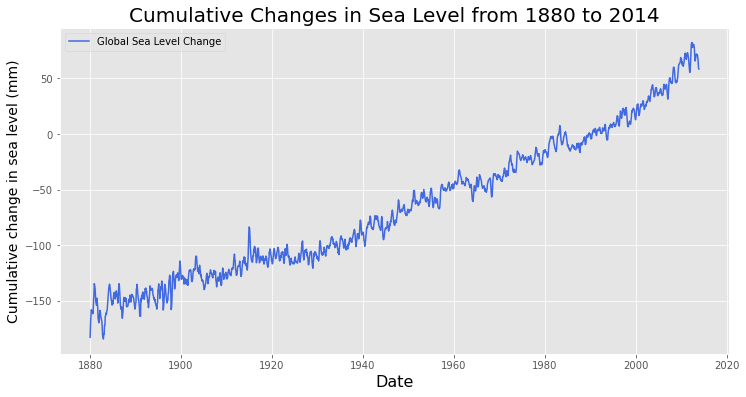

In [23]:
# Plot the global mean sea level changes over time
fig = plt.figure(figsize=(12,6))
plt.plot(sea_level.GMSL, color='royalblue', label='Global Sea Level Change')
plt.title('Cumulative Changes in Sea Level from 1880 to 2014', fontsize=20)
plt.ylabel('Cumulative change in sea level (mm)', fontsize=14, color='black')
plt.xlabel('Date', fontsize=16, color='black')
plt.legend()
plt.show()

**Analysis:** There is a clear, upward trend for the data representing the cumulative sea level changes over time. According to this data, the yearly average sea level has risen 1.75 mm per year since 1900.

In [24]:
# Combine the data for the northern and southern ice extent to calculate global change
north_ice.columns = ['north_extent', 'north_missing', 'north_hemisphere']
south_ice.columns = ['south_extent', 'south_missing', 'south_hemisphere']

# Resample the data by monthly average for each hemisphere
ice_extent = north_ice.join(south_ice).resample('MS').mean()
ice_extent = ice_extent[['north_extent', 'south_extent']]
ice_extent.head()

north_extent  south_extent
datetime                              
1978-10-01     10.402667     17.699000
1978-11-01     11.645133     15.896400
1978-12-01     13.667063     10.395250
1979-01-01     15.414000      5.402200
1979-02-01     16.175286      3.141071

In [25]:
# Difference each series with a period of 12 (1 year) to determine how the ice extent has changed over the year
ice_extent_diff = ice_extent.diff(periods=12).dropna()
ice_extent_diff.head()

north_extent  south_extent
datetime                              
1979-10-01     -1.654729      0.121500
1979-11-01     -0.702067     -0.559333
1979-12-01     -0.330796     -1.159450
1980-01-01     -0.552125     -0.840200
1980-02-01     -0.220143     -0.322714

In [26]:
# Add the differenced values for each hemishpere together to determine global ice extent change
ice_extent_diff['global_total_change'] = ice_extent_diff.sum(axis=1)
ice_extent_diff.head()

north_extent  south_extent  global_total_change
datetime                                                   
1979-10-01     -1.654729      0.121500            -1.533229
1979-11-01     -0.702067     -0.559333            -1.261400
1979-12-01     -0.330796     -1.159450            -1.490246
1980-01-01     -0.552125     -0.840200            -1.392325
1980-02-01     -0.220143     -0.322714            -0.542857

In [27]:
# Combine the global ice extent change data with the sea level data for granger testing
sea_level_ice = sea_level.join(ice_extent_diff).dropna()
sea_level_ice = sea_level_ice[['GMSL', 'global_total_change']]
sea_level_ice.head()

GMSL  global_total_change
datetime                             
1979-10-01 -14.9            -1.533229
1979-11-01 -17.2            -1.261400
1979-12-01 -15.0            -1.490246
1980-01-01 -15.2            -1.392325
1980-02-01 -14.1            -0.542857

In [44]:
# Check for stationarity in global mean sea level change data

# Raw
print('Raw sea level change values:\n')
dickey_fuller_test(sea_level_ice.GMSL) # Nope. p-value of 0.95
print('\n')
# One lag difference
sea_diff1 = sea_level_ice.GMSL.diff(periods=1).dropna()
print('One lag differenced sea level change values:\n')
dickey_fuller_test(sea_diff1) # Yup! p-value of basically 0 using 11 lags

Raw sea level change values:

Results of Dickey-Fuller Test:
Test Statistic                  -0.022619
p-value                          0.956621
#Lags Used                      12.000000
Number of Observations Used    398.000000
Critical Value (1%)             -3.446888
Critical Value (5%)             -2.868829
Critical Value (10%)            -2.570653
dtype: float64


One lag differenced sea level change values:

Results of Dickey-Fuller Test:
Test Statistic                -8.529286e+00
p-value                        1.048310e-13
#Lags Used                     1.100000e+01
Number of Observations Used    3.980000e+02
Critical Value (1%)           -3.446888e+00
Critical Value (5%)           -2.868829e+00
Critical Value (10%)          -2.570653e+00
dtype: float64


In [45]:
# Check for stationarity in global total ice extent data

# Raw
print('Raw total ice extent values:\n')
dickey_fuller_test(sea_level_ice.global_total_change) # Yup! p-value of 0.0003 using 17 lags


Raw total ice extent values:

Results of Dickey-Fuller Test:
Test Statistic                  -4.365851
p-value                          0.000341
#Lags Used                      17.000000
Number of Observations Used    393.000000
Critical Value (1%)             -3.447099
Critical Value (5%)             -2.868923
Critical Value (10%)            -2.570703
dtype: float64


In [46]:
# Based on the results from the Augmented Dickey-Fuller Test, the global mean sea level time series is 
# stationary with a difference order of 1, while the total ice extent data is stationary in its raw form and at a 
# difference order of 1. The differenced time series will be used with the VAR model to select 
# the lag order for the Granger Causality Test.

# Difference the time series based on the results of the Dickey-Fuller test
sea_level_ice_diff = sea_level_ice.diff(periods=1).dropna()

# Instantiate VAR model to select order
order_model = VAR(sea_level_ice_diff)

# Loop through orders and record AIC scores
order_select = []
for p_order in list(range(1,20)):
    results = order_model.fit(p_order)
    order_select.append([p_order, results.aic])
    #print('Order:', p_order, ' AIC:', results.aic)

# Display the order with the lowest AIC score
print('Best order for Granger Causality Test:', sorted(order_select, key= lambda x: x[1], reverse=False)[0][0])

Best order for Granger Causality Test: 16


In [47]:
# The VAR model with the lowest AIC had an order of 16. This value will be used as the max value for the Granger
# Causality Test

display_granger_results(sea_level_ice_diff, 16)

SIGNIFICANT RESULTS FOUND BY LAG -- 2 

P-Values:

Sum of Squares of the Residuals F-Test: 0.042268230480631684
Sum of Squares of the Residuals Chi Squared Test: 0.03962684757925744
Likelihood-Ratio Test: 0.04064125355255189
Joint Model Parameters F-Test: 0.042268230480632885


**Analysis:** Significant findings were established by the 2nd lag, suggesting the changes in global ice extent are participating in changing the global sea levels. Because the cumulative changes in global sea levels have been positive since 1983 and the global ice extent has been trending negative over roughly the same time period, it can be suggested that the increase in global sea levels is related to the diminishing global ice extent.

To estimate the volume of water added to the oceans from the ice extent loss, we will assume that the total ice extent resembles a cube. In October of 1978, the total ice extent was 28.102 million $km^{2}$ and the total ice extent in October of 2018 was 23.729 million $km^{2}$. This equates to loss of 4.383 million $km^{2}$ over 40 years. Since the surface to volume ratio of this massive ice cube to the water composing it would be 6 to 1, the volume of the ice extent cube would equal 0.730 million $km^{3}$ (4.383 million $km^{2}$ / 6). Because one cubic kilometer of water is roughly 2.642 x $10^{11}$ gallons, 0.730 x $10^{6}$ $km^{3}$ ice extent volume multiplied by 2.642 x $10^{11}$ gallons would estimate that 1.93 x $10^{17}$ gallons of water have been added to the worlds oceans.




# Part 4: Greenhouse Gases

### Source: https://www1.ncdc.noaa.gov/pub/data/paleo/icecore/antarctica/law/law2006.txt

In [50]:
##### Helper functions to format ice and gas age values

# Convert "gas age" to year CE
def gas_age_to_year(gas_age):
    '''Convert gas age to year CE
    
    gas_age: how old the gas is in gas years; integer
    
    returns integer of how old the gas is from 0 CE
    '''
    
    # Conditional to deal with gas from before 1950
    if gas_age <= 0:
        
        # Convert the gas age to negative value and add 1950 (Negative values will indicate BCE)
        year = 1950 + (gas_age * -1)
    
    # Conditional to deal with gas age from after 1950
    else:
        
        # Subtract gas age from 1950 
        year = 1950 - gas_age
    
    # Return the converted age of the gas
    return year

# Convert year CE to gas age
def year_to_gas_age (year):
    '''Convert year CE to gas age
    
    year: age of the gas from 0 CE; integer
    
    returns an integer representing the gas age from 1950
    '''
    
    # Conditional to deal with gas from after 1950
    if year >= 1950:
        
        # Subtract the 1950 from the year and convert to negative values
        gas_age = 0 - (year-1950)
        
    # Conditional to deal with gas from before 1950
    else:
        
        # Subtract the year from 1950
        gas_age = 0 + (1950-year)
    
    # Return the calculated gas age 
    return gas_age

# Add month and day values to help with datetime formatting 
def add_month_and_day(year):
    '''Add month and day values to help with datetime formatting
    
    year: the year for the age of the gas; string
    
    returns a string in the form of year-01-01 to allow for datetime conversion
    '''
    
    # String variable to add to year string
    to_add = '-01-01'
    
    # Add the month-day string variable to the year string
    new_value = year + to_add
    
    # Return the combined year-month-day string
    return new_value

In [51]:
# Read in GHG ice core data
icecore = pd.read_excel('ice_core/ice_core_gases.xlsx')

# Format column names
icecore.columns = ['YearAD', 'CH4ppb', 'CH4_growth_ppb_yr', 'NOAA04', 'CO2ppm', 'CO2_growth_ppm_yr', 'N2Oppb', 
                  'N2O_growth_ppm_yr']

# Calculate gas age from year CE to aid in visualization
icecore['gas_age'] = icecore.YearAD.map(year_to_gas_age)
icecore.head()

YearAD  CH4ppb  CH4_growth_ppb_yr  NOAA04  CO2ppm  CO2_growth_ppm_yr  \
0       1   647.6               -0.5   655.5   276.7                0.1   
1       2   647.1               -0.5   655.0   276.8                0.1   
2       3   646.5               -0.5   654.4   276.8                0.1   
3       4   646.0               -0.5   653.9   276.9                0.1   
4       5   645.5               -0.5   653.4   276.9                0.1   

   N2Oppb  N2O_growth_ppm_yr  gas_age  
0   264.2               -0.1     1949  
1   264.1               -0.1     1948  
2   264.1               -0.1     1947  
3   264.0               -0.1     1946  
4   264.0               -0.1     1945

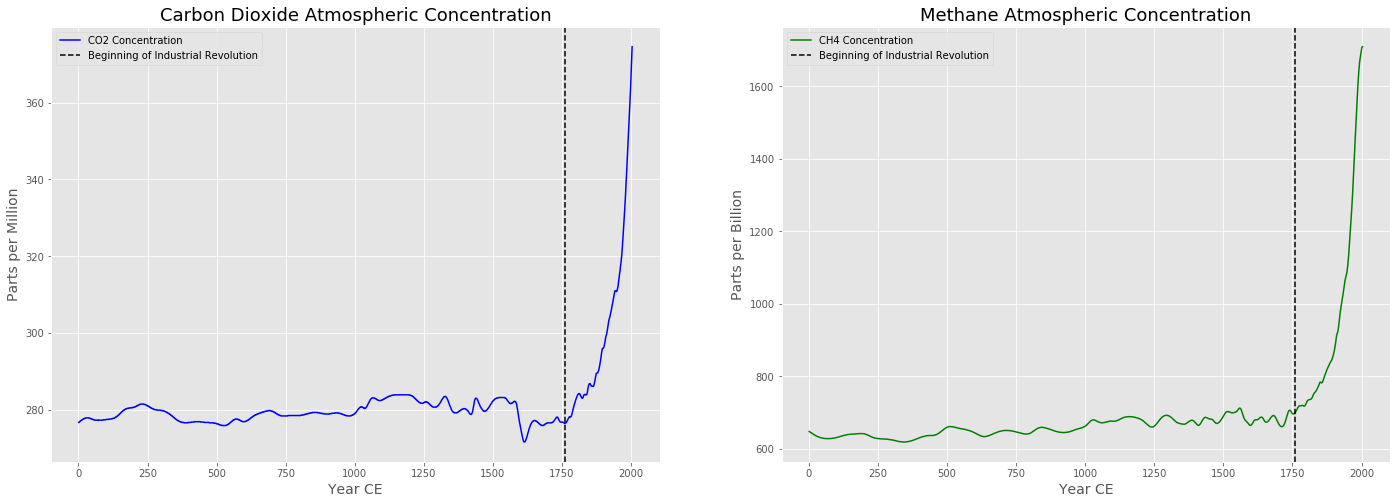

In [52]:
# Create the figure with subplots
fig, ax = plt.subplots(1, 2, figsize=(24, 8))

# Plot changes in carbon dioxide conc. over time 
ax[0].plot(icecore.YearAD, icecore.CO2ppm, color='blue', label='CO2 Concentration')
ax[0].set_title('Carbon Dioxide Atmospheric Concentration', fontsize=18)
ax[0].axvline(1760, color='black', ls="--", label='Beginning of Industrial Revolution') # Mark the start of industrial
                                                                                        # revolution
ax[0].set_ylabel('Parts per Million', fontsize=14)
ax[0].set_xlabel('Year CE', fontsize=14)
ax[0].legend()

# Plot changes in methane conc. over time
ax[1].plot(icecore.YearAD, icecore.CH4ppb, color='green', label='CH4 Concentration')
ax[1].axvline(1760, color='black', ls="--", label='Beginning of Industrial Revolution') # Mark the start of industrial
                                                                                        # revolution
ax[1].set_title('Methane Atmospheric Concentration', fontsize=18)
ax[1].set_ylabel('Parts per Billion', fontsize=14)
ax[1].set_xlabel('Year CE', fontsize=14)
ax[1].legend()

# ax[2].plot(icecore.YearAD, icecore.N2Oppb, color='red', label='N2O Concentration')
# ax[2].axvline(1760, color='black', ls="--", label='Beginning of Industrial Revolution')
# ax[2].set_title('Dinitrogen Oxide Atmospheric Concentration', fontsize=18)
# ax[2].set_ylabel('Parts per Billion', fontsize=14)
# ax[2].set_xlabel('Year CE', fontsize=14)
# ax[2].legend()

plt.show()

**Analysis:** The values of atmospheric concentrations of carbon dioxide and methane remained relatively stable from 0 CE to 1760 CE (the beginning of the industrial revolution) and then began to increase exponentially. This is not surprising as the production and usage of GHG-producing machines rose from that time.

In [53]:
# Isolate the data corresponding to the period of 1700 to present (datetime does not recognize dates prior to 1700)
icecore1700 = icecore.loc[icecore.YearAD >= 1700]

# Format column names
icecore1700.columns = ['year_CE', 'ch4_ppb', 'ch4_growth_ppb_yr', 'NOAA04', 'co2_ppm', 'co2_growth_ppm_yr',
                      'n2o_ppb', 'n2o_growth_ppm_yr', 'gas_age']

# Create datetime column and set as index
icecore1700.year_CE = icecore1700.year_CE.astype('str')
icecore1700.year_CE = icecore1700.year_CE.map(add_month_and_day)
icecore1700.year_CE = pd.to_datetime(icecore1700.year_CE)
icecore1700.set_index('year_CE', inplace=True)

print(icecore1700.shape)
icecore1700.head()

(305, 8)


ch4_ppb  ch4_growth_ppb_yr  NOAA04  co2_ppm  co2_growth_ppm_yr  \
year_CE                                                                      
1700-01-01    669.2               -1.3   677.4    276.6                0.0   
1701-01-01    667.9               -1.2   676.1    276.6                0.0   
1702-01-01    666.7               -1.2   674.9    276.6                0.0   
1703-01-01    665.6               -1.1   673.7    276.6                0.0   
1704-01-01    664.6               -1.0   672.7    276.6                0.0   

            n2o_ppb  n2o_growth_ppm_yr  gas_age  
year_CE                                          
1700-01-01    271.2                0.0      250  
1701-01-01    271.2                0.0      249  
1702-01-01    271.2                0.0      248  
1703-01-01    271.2                0.0      247  
1704-01-01    271.1                0.0      246

In [54]:
# Combine temperature anomaly data with carbon dioxide growth data for granger testing
temp_co2 = zonal_changes.join(icecore1700.co2_growth_ppm_yr).dropna()
temp_co2 = temp_co2[['Glob', 'co2_growth_ppm_yr']]
temp_co2.head()

Glob  co2_growth_ppm_yr
Year                               
1880-01-01 -0.17                0.1
1881-01-01 -0.09                0.2
1882-01-01 -0.11                0.2
1883-01-01 -0.17                0.2
1884-01-01 -0.29                0.3

In [55]:
# Check for stationarity in carbon dioxide data

#co2_log = np.log(temp_co2.co2_growth_ppm_yr)

# Raw
print('Raw CO2 growth values:\n')
dickey_fuller_test(temp_co2.co2_growth_ppm_yr) # Nope. p-value of 0.99
print('\n')
# # Log CO2
# print('Log CO2 conc. values:\n')
# dickey_fuller_test(co2_log) # Nope. p-value of 0.99
# print('\n')
# One lag difference
co2_diff1 = temp_co2.co2_growth_ppm_yr.diff(periods=1).dropna()
print('One lag differenced CO2 growth values:\n')
dickey_fuller_test(co2_diff1) # Nope. p-value of 0.99
print('\n')
# Two lag difference
co2_diff2 = temp_co2.co2_growth_ppm_yr.diff(periods=2).dropna()
print('Two lag differenced CO2 growth values:\n')
dickey_fuller_test(co2_diff2) # Nope. p-value of 0.99
print('\n')
# Three lag difference
co2_diff3 = temp_co2.co2_growth_ppm_yr.diff(periods=3).dropna()
print('Three lag differenced CO2 growth values:\n')
dickey_fuller_test(co2_diff3) # Nope. p-value of 0.99


Raw CO2 growth values:

Results of Dickey-Fuller Test:
Test Statistic                  -2.361230
p-value                          0.152979
#Lags Used                       1.000000
Number of Observations Used    123.000000
Critical Value (1%)             -3.484667
Critical Value (5%)             -2.885340
Critical Value (10%)            -2.579463
dtype: float64


One lag differenced CO2 growth values:

Results of Dickey-Fuller Test:
Test Statistic                  -2.393256
p-value                          0.143649
#Lags Used                       0.000000
Number of Observations Used    123.000000
Critical Value (1%)             -3.484667
Critical Value (5%)             -2.885340
Critical Value (10%)            -2.579463
dtype: float64


Two lag differenced CO2 growth values:

Results of Dickey-Fuller Test:
Test Statistic                  -2.849423
p-value                          0.051553
#Lags Used                       5.000000
Number of Observations Used    117.000000
Critical Valu

In [56]:
# Difference the time series based on the results of the Dickey-Fuller Test
temp_co2_diff = temp_co2.diff(3).dropna()

# Instantiate a VAR model for order selection
order_model = VAR(temp_co2_diff)

# Loop through order values and record AIC
for p_order in list(range(1,11)):
    results = order_model.fit(p_order)
    print('Order:', p_order, ' AIC:', results.aic)

Order: 1  AIC: -7.050247889760079
Order: 2  AIC: -7.093814718181435
Order: 3  AIC: -7.220994183065123
Order: 4  AIC: -7.2387814606847884
Order: 5  AIC: -7.34133261649748
Order: 6  AIC: -7.3362202948852255
Order: 7  AIC: -7.332830064920233
Order: 8  AIC: -7.282477746337058
Order: 9  AIC: -7.232276650114029
Order: 10  AIC: -7.2360305428055245


In [57]:
# The order of the VAR model with the lowest AIC value is 5. Thus, the Granger Causality test will be performed for 
# 5 lags

display_granger_results(temp_co2_diff, 5)

No significant results found in 5 lags


**Analysis:** The Granger Causality Test did not return any significant results for carbon dioxide growth on temperature anomaly when analyzed out to 5 lags. The growth of atmospheric carbon dioxide was used for this analysis instead of the actual carbon dioxide atmospheric concentration values because the Granger Causality test requires stationarity and the extreme growth of atmospheric carbon dioxide was unable to be made stationary after considerable effort (differenced the log of carbon dioxide concentration out to 20 periods). If the actual values of carbon dioxide concentration can be made stationary, the Granger Causality Test may return significant results for their effect on temperature as there is concensus among climate scientists that GHG contribute to global warming.

In [58]:
# Combine methane growth data with temperature anomaly data for granger testing
temp_ch4 = zonal_changes.join(icecore1700.ch4_growth_ppb_yr).dropna()
temp_ch4 = temp_ch4[['Glob', 'ch4_growth_ppb_yr']]
temp_ch4.head()

Glob  ch4_growth_ppb_yr
Year                               
1880-01-01 -0.17                1.7
1881-01-01 -0.09                1.8
1882-01-01 -0.11                1.9
1883-01-01 -0.17                1.9
1884-01-01 -0.29                1.9

In [59]:
# Check for stationarity in carbon dioxide data


# Raw
print('Raw CH4 conc. values:\n')
dickey_fuller_test(temp_ch4.ch4_growth_ppb_yr) # Nope. p-value of 0.99
print('\n')
# # Log CO2
# print('Log CO2 conc. values:\n')
# dickey_fuller_test(co2_log) # Nope. p-value of 0.99
# print('\n')
# One lag difference
ch4_diff1 = temp_ch4.ch4_growth_ppb_yr.diff(periods=1).dropna()
print('One lag differenced log CH4 conc. values:\n')
dickey_fuller_test(ch4_diff1) # Nope. p-value of 0.99
# print('\n')
# # Two lag difference
# ch4_diff2 = temp_ch4.ch4_growth_ppb_yr.diff(periods=2).dropna()
# print('Two lag differenced log CH4 conc. values:\n')
# dickey_fuller_test(ch4_diff1) # Nope. p-value of 0.99
# print('\n')
# # Three lag difference
# ch4_diff3 = temp_ch4.ch4_growth_ppb_yr.diff(periods=3).dropna()
# print('Three lag differenced log CH4 conc. values:\n')
# dickey_fuller_test(ch4_diff3) # Nope. p-value of 0.99

Raw CH4 conc. values:

Results of Dickey-Fuller Test:
Test Statistic                  -1.478951
p-value                          0.543897
#Lags Used                       3.000000
Number of Observations Used    121.000000
Critical Value (1%)             -3.485585
Critical Value (5%)             -2.885739
Critical Value (10%)            -2.579676
dtype: float64


One lag differenced log CH4 conc. values:

Results of Dickey-Fuller Test:
Test Statistic                  -4.448209
p-value                          0.000244
#Lags Used                       2.000000
Number of Observations Used    121.000000
Critical Value (1%)             -3.485585
Critical Value (5%)             -2.885739
Critical Value (10%)            -2.579676
dtype: float64


In [60]:
# Difference the time series based on the results from the Dickey-Fuller test
temp_ch4_diff = temp_ch4.diff(1).dropna()

# Instantiate VAR model for order selection
order_model = VAR(temp_ch4_diff)

# Loop through the orders and record AIC values
for p_order in list(range(1,11)):
    results = order_model.fit(p_order)
    print('Order:', p_order, ' AIC:', results.aic)

Order: 1  AIC: -6.33316734801643
Order: 2  AIC: -6.722126561246974
Order: 3  AIC: -6.750593105698803
Order: 4  AIC: -6.734885429904314
Order: 5  AIC: -6.76043767269015
Order: 6  AIC: -6.708561653597806
Order: 7  AIC: -6.660745090827895
Order: 8  AIC: -6.647080565309986
Order: 9  AIC: -6.583000570784511
Order: 10  AIC: -6.5720209576194755


In [61]:
# The order of the VAR model with the lowest AIC value is 5. Thus, the Granger Causality test will be performed for 
# 5 lags

display_granger_results(temp_ch4_diff, 5)

No significant results found in 5 lags


**Analysis:** Again, the Granger Causality Test did not return any significant results for methane growth on temperature anomaly when analyzed out to 5 lags. The growth of atmospheric methane was used for this analysis instead of the actual methane atmospheric concentration values because the Granger Causality test requires stationarity and the extreme growth of atmospheric methane was unable to be made stationary after considerable effort (differenced the log of methane concentration out to 20 periods). If the actual values of methane concentration can be made stationary, the Granger Causality Test may return significant results for their effect on temperature as there is concensus among climate scientists that GHG contribute to global warming.

### Temperature and GHG Measurements for the Last 400,000 Years

The data used in this section contains Vostok Ice Core Data for 420,000 Years. The data covers the last 4 ice age cycles. Data can be used to study natural atmospheric gas levels, dust levels, and natural variation in temperatures. The natural variations over the last 4 ice ages would be useful for comparison to the anthropogenic climate-change data available for the modern industrial period. The dataset contains information on GT4 ice core chronology (gas and ice chronology), Deuterium and reconstructed temperature, Dust content, Sodium concentrations, CO$_{2}$, CH$_{4}$, atmospheric oxygen composition. The original text files were reformated by removing header information and converting to CSV format.

Source: https://www.kaggle.com/grudd0/vostok-ice-core

In [28]:
# Read historical icecore temperature measurements
icecore_temp = pd.read_csv('Data/deuterium_and_temp.csv')

# Read historical icecore methane measurements
ch4 = pd.read_csv('Data/methane.csv')

# Read historical icecore carbon dioxide measurements
co2 = pd.read_csv('Data/carbon_dioxide.csv')

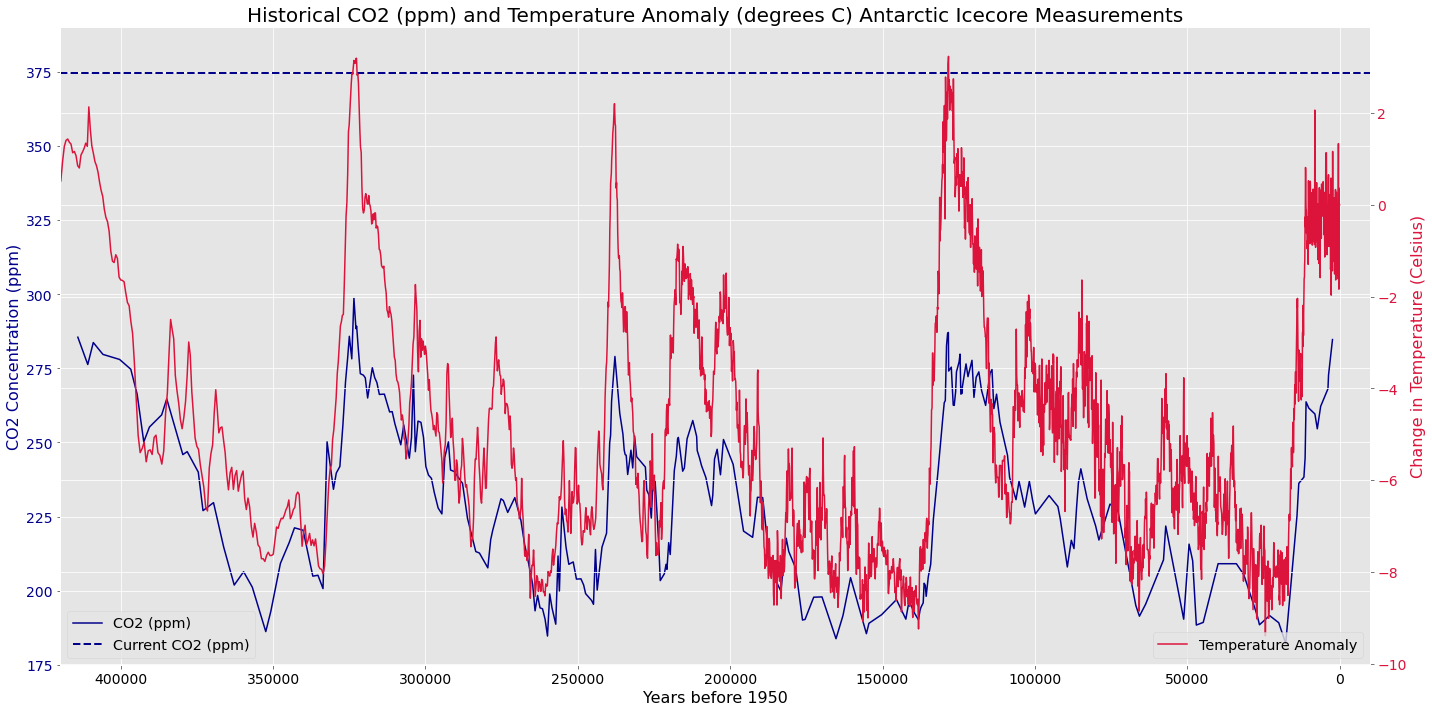

In [29]:
# Create figure to display historical temperature anomaly and carbon dioxide concentration
fig, ax1 = plt.subplots(figsize=(20,10))

ax1.plot(co2['Gas age '], co2['CO2 (ppmv)'], color='darkblue', label='CO2 (ppm)') # Historical CO2 values
ax1.axhline(374.6, ls="--", color='darkblue', lw=2, label='Current CO2 (ppm)') # Current CO2 value
ax1.tick_params(axis='y', labelcolor='darkblue', labelsize=14)
ax1.tick_params(axis='x', labelcolor='black', labelsize=14)
ax1.set_ylim(175, 390) 
ax1.set_xlim(420000, -10000)
ax1.set_xlabel('Years before 1950', fontsize=16, color='black')
ax1.set_ylabel('CO2 Concentration (ppm)', fontsize=16, color='darkblue')
ax1.legend(loc='lower left', fontsize='x-large')

# Create another y-axis for temperature anomaly
ax2 = ax1.twinx()

# Historical temperature anomaly values
ax2.plot(icecore_temp['Ice age (GT4)'], icecore_temp['deltaTS'], color='crimson', label='Temperature Anomaly')
ax2.set_ylabel('Change in Temperature (Celsius)', fontsize=16, color='crimson')
ax2.tick_params(axis='y', labelcolor='crimson', labelsize=14)

ax2.legend(loc='lower right', fontsize='x-large')
plt.title('Historical CO2 (ppm) and Temperature Anomaly (degrees C) Antarctic Icecore Measurements', fontsize=20)
fig.tight_layout()
plt.show()

**Analysis:** The temperature anomaly and carbon dioxide measurements seem to correlate over the past 400,000 years, indicating that there is most likely a connection between carbon dioxide and temperature changes. The dashed line at the top of the graph represents the current atmospheric carbon dioxide value and it is almost 75 ppm greater than any value in the past 400,000 years.

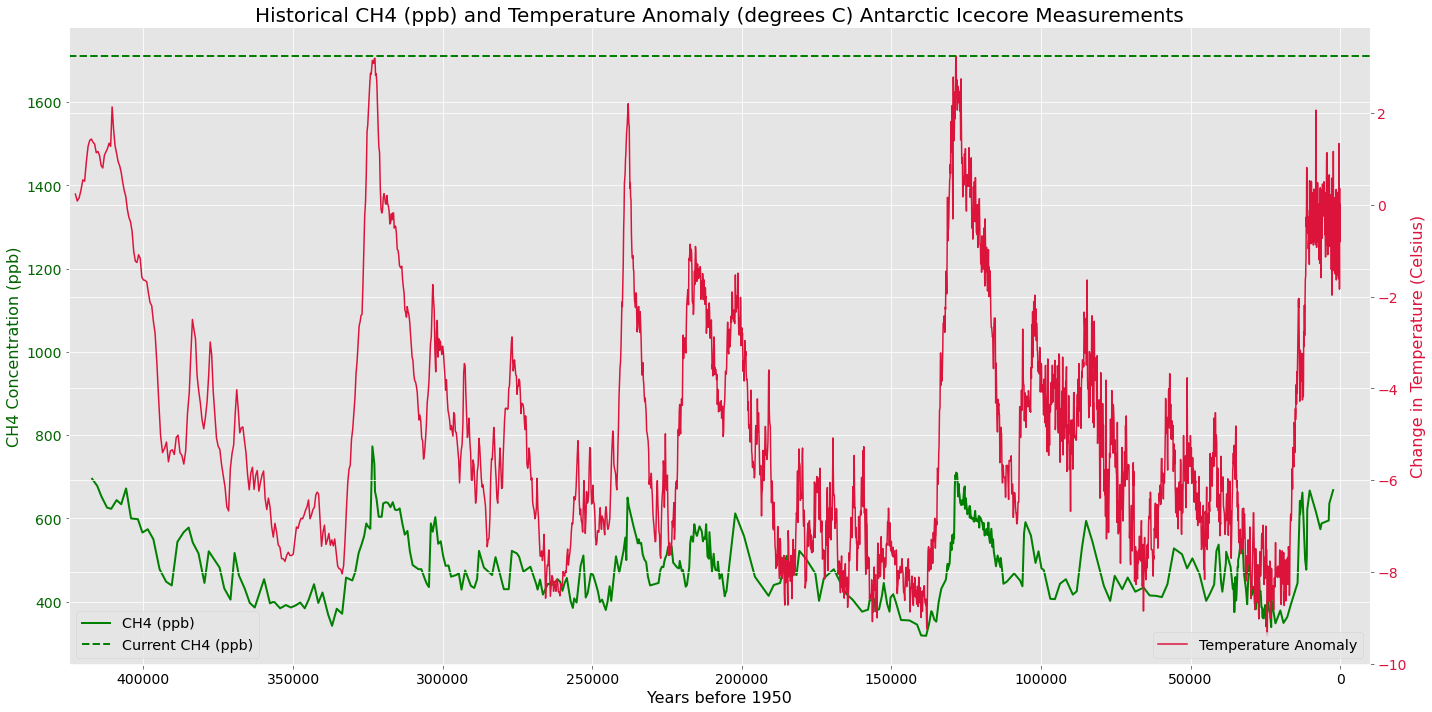

In [30]:
fig, ax1 = plt.subplots(figsize=(20,10))
ax1.plot(ch4['Gas age'], ch4['CH4 (ppbv)'], color='green', lw=2, label='CH4 (ppb)')
ax1.axhline(1709.7, ls="--", color='green', lw=2, label='Current CH4 (ppb)')
ax1.tick_params(axis='y', labelcolor='darkgreen', labelsize=14)
ax1.tick_params(axis='x', labelcolor='black', labelsize=14)
#ax1.set_ylim(310, 1000)
ax1.set_xlim(425000, -10000)
ax1.set_xlabel('Years before 1950', fontsize=16, color='black')
ax1.set_ylabel('CH4 Concentration (ppb)', fontsize=16, color='darkgreen')
ax1.legend(loc='lower left', fontsize='x-large')

ax2 = ax1.twinx()

ax2.plot(icecore_temp['Ice age (GT4)'], icecore_temp['deltaTS'], color='crimson', label='Temperature Anomaly')

ax2.set_ylabel('Change in Temperature (Celsius)', fontsize=16, color='crimson')
ax2.tick_params(axis='y', labelcolor='crimson', labelsize=14)

ax2.legend(loc='lower right', fontsize='x-large')
plt.title('Historical CH4 (ppb) and Temperature Anomaly (degrees C) Antarctic Icecore Measurements', fontsize=20)
fig.tight_layout()
plt.show()

**Analysis:** Temperature anomaly and methane measurements also seem to correlate over the past 400,000 years, indicating that there is most likely also a connection between methane and temperature changes. The dashed line at the top of the graph represents the current atmospheric methane concentration and it is more than 2 times greater than any value in the past 400,000 years.

### Conclusion for The Role of Greenhouse Gases in Global Warming

While the Granger Causality Test did not yield any significant results, the historical correlation of carbon dioxide and methane with temperature changes over the past 400,000 years seems to be very strong. The insignificant results may be due to the bidirectional correlation between GHGs and temperature suggested by the climate science community and the assumptions of the Granger Causality Test. Rising temperatures results in increased ice melt, which results in the release of GHGs stored in the now-melted ice. As one of the assumptions of the Granger Causality Test is that the cause has to preceed the effect, increasing temperatures occurring before increasing GHGs from ice melt would violate this assumption since we formatted the data to test if rising GHGs caused a rise temperature. As most climate scientists agree on the causal role of GHGs in global warming trends, further testing should be performed illuminate this role.




# Modeling Global Warming Trends

<br><br>
## 1A.Temperature Anomaly

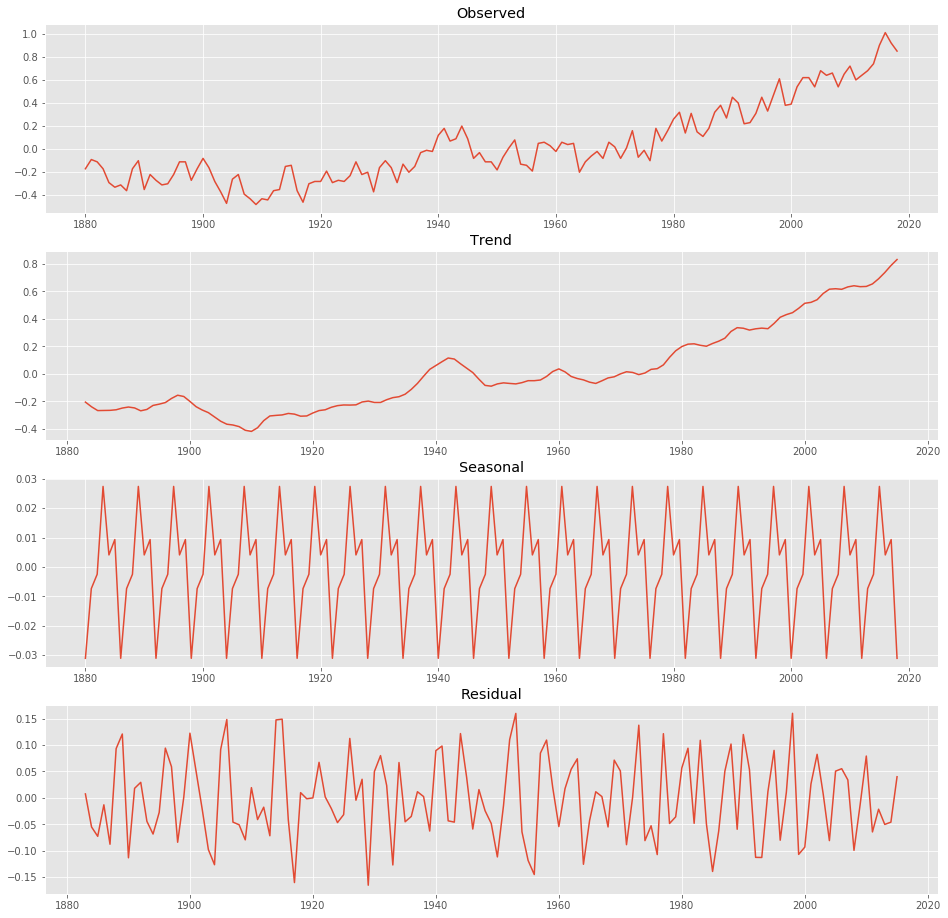

In [65]:
# Decompose the temperature anomaly time series into its trend, seasonal, and residual components

temp_decomp = seasonal_decompose(zonal_changes.Glob, freq=6) # Freq=6 due to El Niño–Southern Oscillation (ENSO)
plot_decompose(temp_decomp)

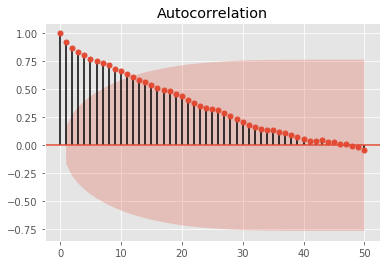

In [66]:
# Display the Autocorrelation function
plot_acf(zonal_changes.Glob, lags=50);

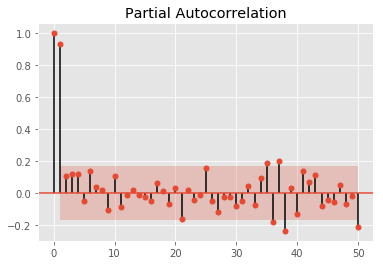

In [67]:
# Display the partial autocorrelation function
plot_pacf(zonal_changes.Glob, lags=50);

In [68]:
# Perform a grid search for the orders of a SARIMA model
temp_params = grid_search_arima(range(1,3), 6, zonal_changes.Glob)

In [41]:
# Obtain the orders of the model with the lowest AIC and BIC scores
print(f"Best Parameters by AIC: {temp_params.loc[temp_params['aic'].idxmin()]}")
print(f"Best Parameters by BIC: {temp_params.loc[temp_params['bic'].idxmin()]}")

Best Parameters by AIC: pdq        (2, 1, 1)
pdqs    (1, 1, 1, 6)
aic         -185.545
bic         -168.623
Name: 32, dtype: object
Best Parameters by BIC: pdq        (1, 1, 1)
pdqs    (1, 1, 1, 6)
aic         -184.672
bic         -170.571
Name: 0, dtype: object


In [69]:
# Split the temperature anomaly time series into a training and test set
train_temp = zonal_changes.Glob.iloc[:-30]
test_temp = zonal_changes.Glob.iloc[-30:]

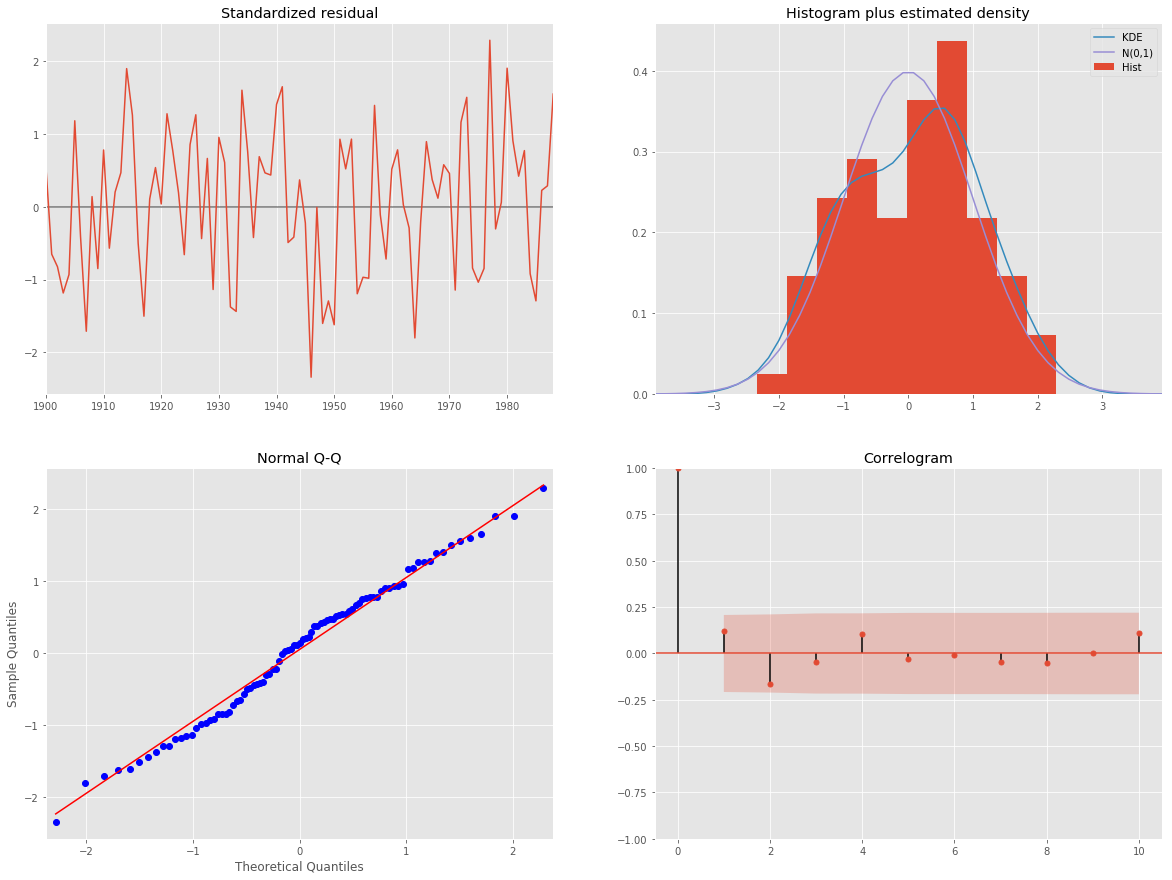

Model Performance Measures:
Root Mean Squared Error: 0.10073793374249695
R-Squared: 0.7469181741158673


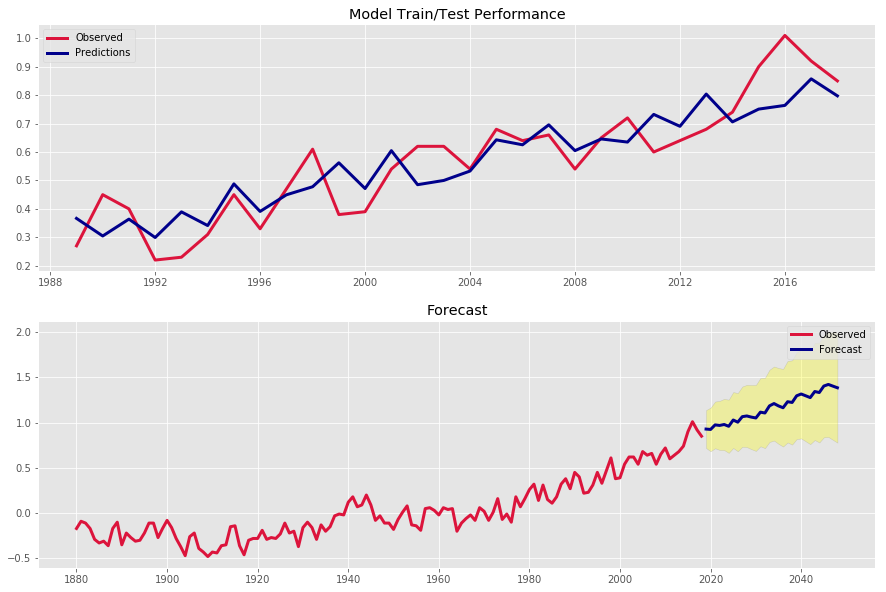

In [63]:
# Evaluate the model parameters with the best AIC score
sarimax_eval(train_temp, test_temp, zonal_changes.Glob, 30, (1,1,1), (2,1,1,6), 'n', enforce=False)

**Analysis:** The SARIMA model with the parameters that returned the lowest AIC satisfy the stationarity, normality, and homoskedasticity assumptions as demonstrated by the first four subplots. Additionally, the predictions have an R-squared value of 0.746 when compared to the test set observations and the root mean squared error of the predictions is less than the standard deviation of the test set.
<br>

## 1B. Forecast Temperature Anomaly to Estimate When Critical Value of 2.0 C Will be Reached

In [7]:
# Instantiate the final SARIMA model for temperature anomaly data and fit it to entire series
temp_final = SARIMAX(zonal_changes.Glob, order=(1,1,1), seasonal_order=(2,1,1,6), enforce_stationarity=False, 
                   enforce_invertibility=False)
temp_model = temp_final.fit()

In [73]:
# Get forecast 100 steps ahead in future
temp_fcast = temp_model.get_forecast(steps=100, dynamic=True)

# Get confidence intervals of forecasts
temp_conf = temp_fcast.conf_int()

In [79]:
# Determine when forecasted temperature anomalies exceed 2 degrees C
critical_temp = temp_fcast.predicted_mean.loc[temp_fcast.predicted_mean >=2]
critical_temp[0:6]

# The model suggests that the temperature anomaly will reach the 2 degree C critical point in 2081

2081-01-01    2.061802
2082-01-01    2.080941
2083-01-01    2.061225
2084-01-01    2.042518
2085-01-01    2.109306
2086-01-01    2.098825
Freq: AS-JAN, dtype: float64

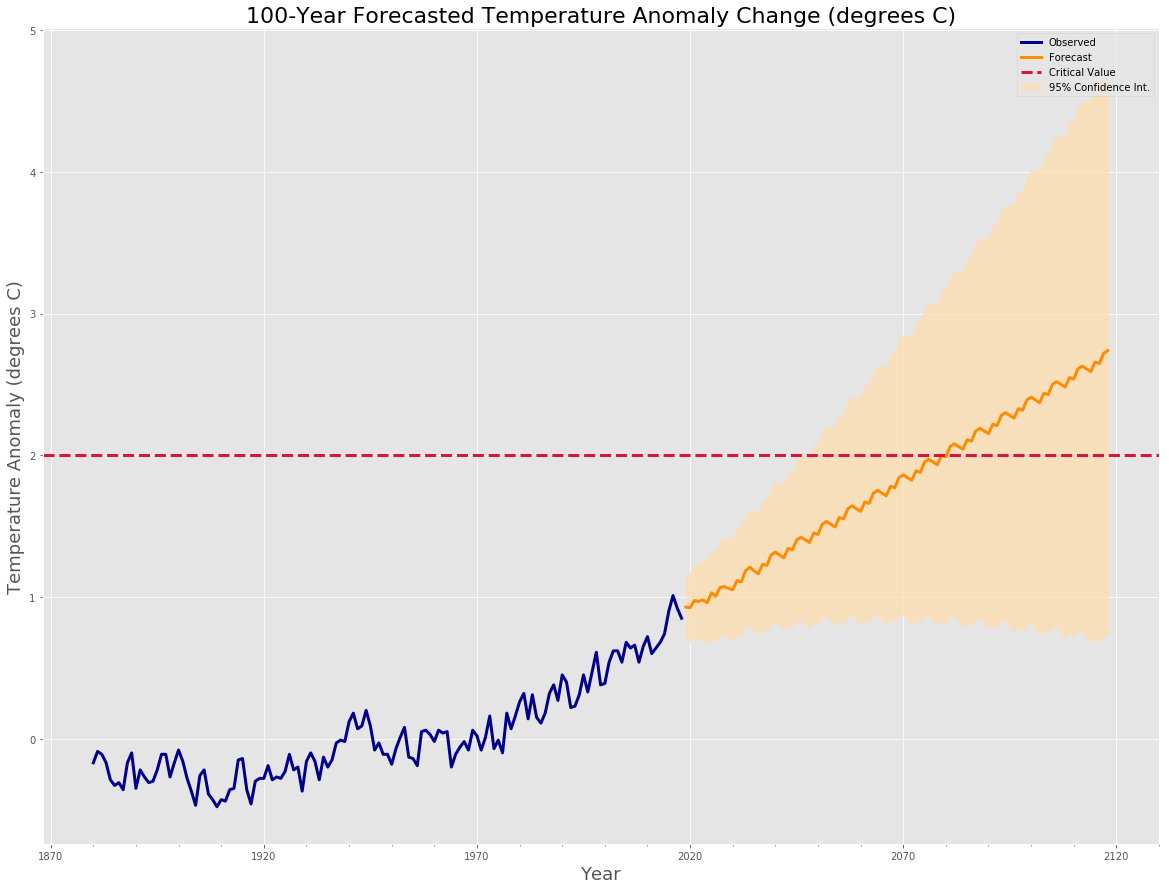

In [80]:
# Plot future predictions with confidence intervals

ax = zonal_changes.Glob.plot(label='Observed', figsize=(20, 15), lw=3, color='darkblue')
temp_fcast.predicted_mean.plot(ax=ax, label='Forecast', color='darkorange', lw=3)
ax.fill_between(temp_conf.index,
                temp_conf.iloc[:, 0],
                temp_conf.iloc[:, 1], color='navajowhite', alpha=.75, label='95% Confidence Int.')
ax.axhline(2.0, ls="--", lw=3, color='crimson', label='Critical Value')
ax.set_xlabel('Year', fontsize=18)
ax.set_ylabel('Temperature Anomaly (degrees C)', fontsize=18)

plt.title('100-Year Forecasted Temperature Anomaly Change (degrees C)', fontsize=22)
plt.legend()
plt.show()

**Analysis:** The temperature anomaly model predicted with 74.6% accuracy on the test set and indicates that the critical value of 2 degrees C will be reached in the year 2081. 
<br><br>

# 2. Ice Extent

- Because the two poles are warming at different rates, the ice extent of each hemisphere will be modeled separately

## A. Northern Hemisphere

In [70]:
# Resample the ice extent data to a monthly frequency for time series modeling
north_ice_monthly = north_ice.resample('MS').mean()
south_ice_monthly = south_ice.resample('MS').mean()
north_ice_monthly.head()

north_extent  north_missing
datetime                               
1978-10-01     10.402667            0.0
1978-11-01     11.645133            0.0
1978-12-01     13.667063            0.0
1979-01-01     15.414000            0.0
1979-02-01     16.175286            0.0

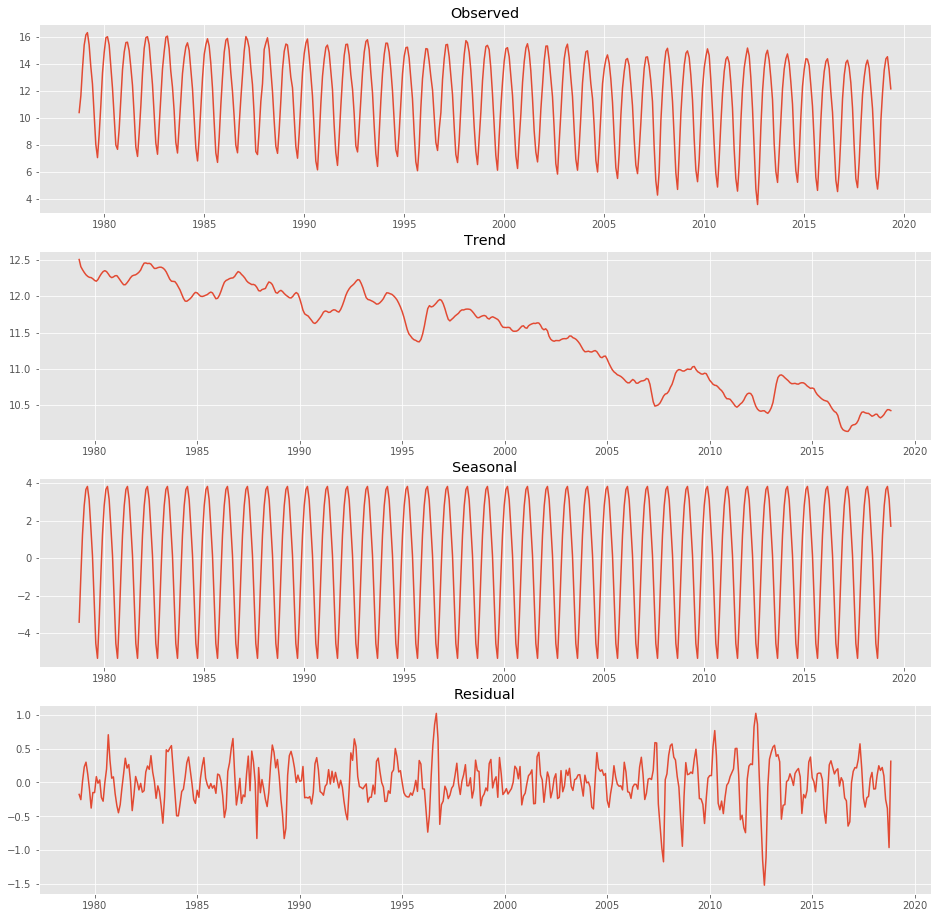

In [72]:
# Decompose the northern hemisphere ice extent time series into its trend, seasonal, and residual components
north_decomp = seasonal_decompose(north_ice_monthly.north_extent)
plot_decompose(north_decomp)

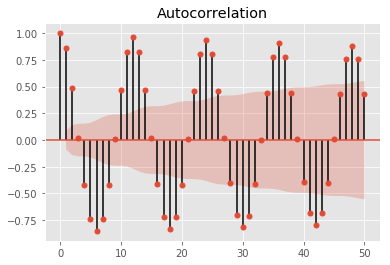

In [73]:
# Plot the autocorrelation function
plot_acf(north_ice_monthly.north_extent, lags=50);

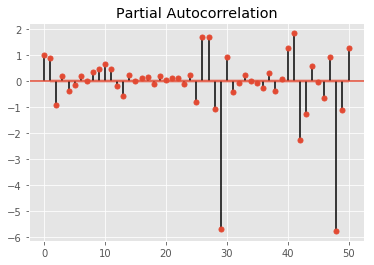

In [74]:
# Plot the partial autocorrelation function
plot_pacf(north_ice_monthly.north_extent, lags=50);

In [75]:
# Perform a grid search for the orders of a SARIMA model
north_params = grid_search_arima(range(0,3), 12, north_ice_monthly.north_extent)

In [91]:
# Obtain the orders of the model with the lowest AIC and BIC scores
print(f"Best Parameters by AIC: {north_params.loc[north_params['aic'].idxmin()]}")
print(f"Best Parameters by BIC: {north_params.loc[north_params['bic'].idxmin()]}")

Best Parameters by AIC: pdq         (1, 1, 2)
pdqs    (1, 0, 1, 12)
aic           38.3591
bic            63.301
Name: 388, dtype: object
Best Parameters by BIC: pdq         (2, 1, 1)
pdqs    (0, 1, 1, 12)
aic           39.4732
bic           60.1402
Name: 598, dtype: object


In [76]:
# Split the data into a training and testing set
train_north = north_ice_monthly.north_extent.iloc[:-180] # 180 months = 15 years
test_north = north_ice_monthly.north_extent.iloc[-180:]

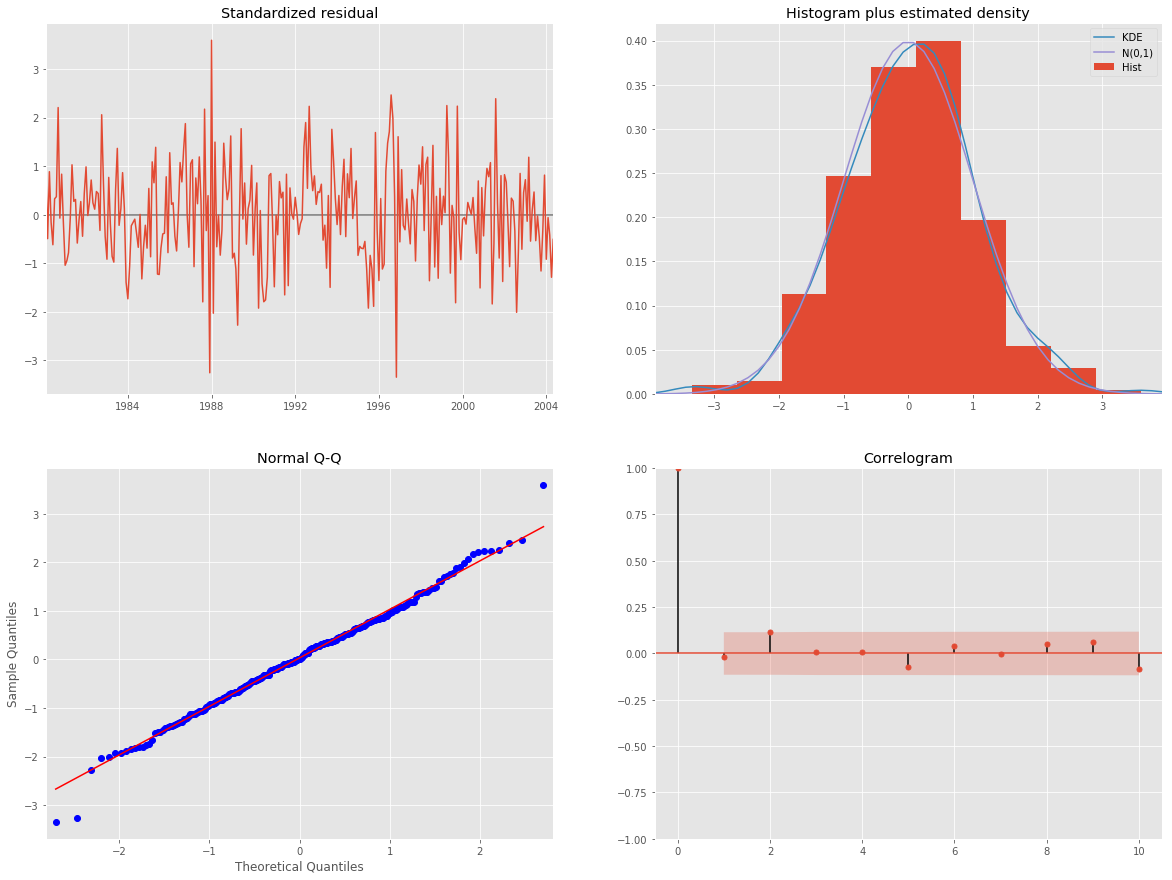

Model Performance Measures:
Root Mean Squared Error: 0.5313177116126091
R-Squared: 0.9751300265281895


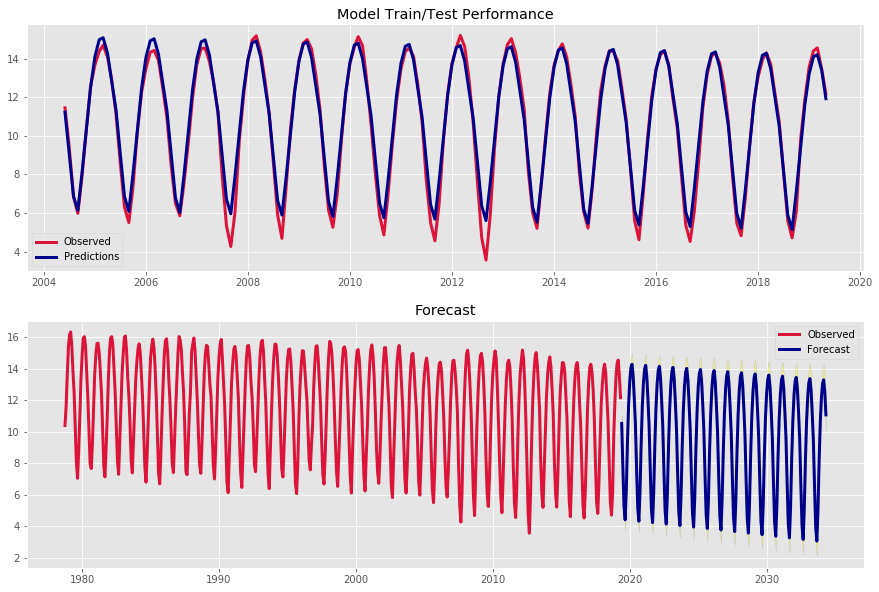

In [114]:
# Evaluate model with AIC parameters
sarimax_eval(train_north, test_north, north_ice_monthly.north_extent, 180, (1,1,2), (1,0,1,12), 'c', enforce=False)

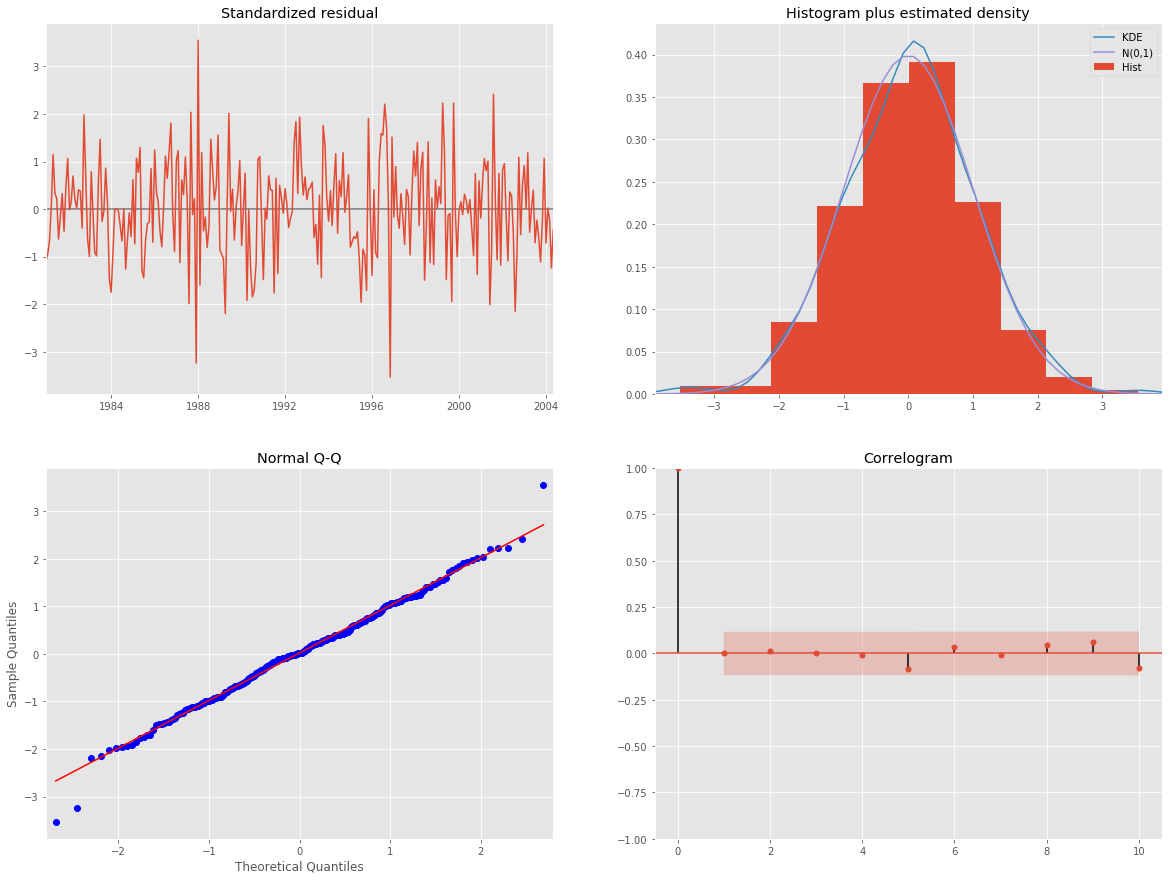

Model Performance Measures:
Root Mean Squared Error: 0.5740585219264269
R-Squared: 0.9709678584951758


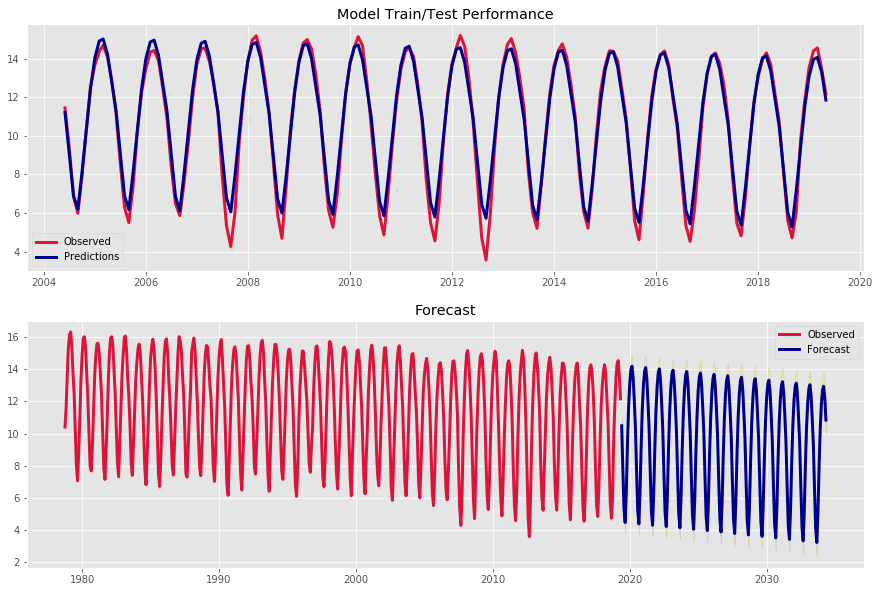

In [106]:
# Evaluate model with BIC parameters
sarimax_eval(train_north, test_north, north_ice_monthly.north_extent, 180, (2,1,1), (0,1,1,12), 'c', enforce=False)

**Analysis:** Both models satisfy the stationarity, normality, and homoskedasticity assumptions. The model using the best AIC parameters had an R-squared score of 0.975, which is 0.005 higher than the R-squared score for the model using the best BIC parameters. Thus, the best AIC parameters will be used to forecast the northern hemisphere ice extent values.

## Forecasted Ice Extent of the Northern Hemisphere

In [77]:
# Instantiate the final SARIMA model for northern hemisphere ice extent data and fit it to entire series
north_final = SARIMAX(north_ice_monthly.north_extent, order=(1,1,2), seasonal_order=(1,0,1,12), trend='c', 
                      enforce_stationarity=False, enforce_invertibility=False)
north_model = north_final.fit()

In [78]:
# Get forecast 600 steps (50 years) ahead in future
north_fcast = north_model.get_forecast(steps=600, dynamic=True)

# Get confidence intervals of forecasts
north_conf = north_fcast.conf_int()

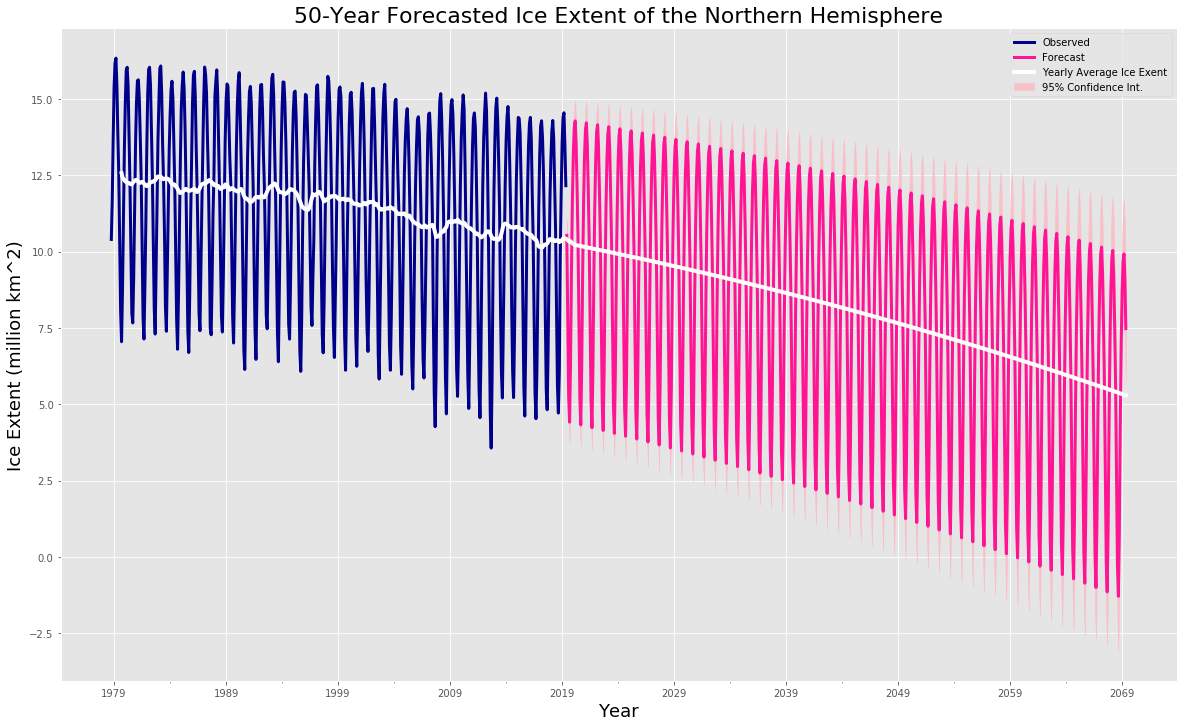

In [79]:
# Plot future predictions with confidence intervals
plt.style.use('ggplot')
north_joined = pd.concat([north_ice_monthly.north_extent, north_fcast.predicted_mean], axis=0)

ax = north_ice_monthly.north_extent.plot(label='Observed', figsize=(20, 12), lw=3, color='darkblue')

north_fcast.predicted_mean.plot(ax=ax, label='Forecast', color='deeppink', lw=3)
ax.fill_between(north_conf.index,
                north_conf.iloc[:, 0],
                north_conf.iloc[:, 1], color='lightpink', alpha=.75, label='95% Confidence Int.')
ax = north_joined.rolling(window=12).mean().plot(label='Yearly Average Ice Exent', color='white', lw=4)
ax.set_xlabel('Year', fontsize=18, color='black')
ax.set_ylabel('Ice Extent (million km^2)', fontsize=18, color='black')

plt.title('50-Year Forecasted Ice Extent of the Northern Hemisphere', fontsize=22, color='black')
plt.legend()
plt.show()

**Analysis:** The ice extent in the northern hemisphere is decreasing at a rate of 0.052 million km$^{2}$ per year since 1978. In fifty years, the model predicts the ice extent of the northern hemisphere will have decreased a total of 5.3 million km$^{2}$, roughly half of the current ice extent.

<br><br>
## B. Southern Hemisphere


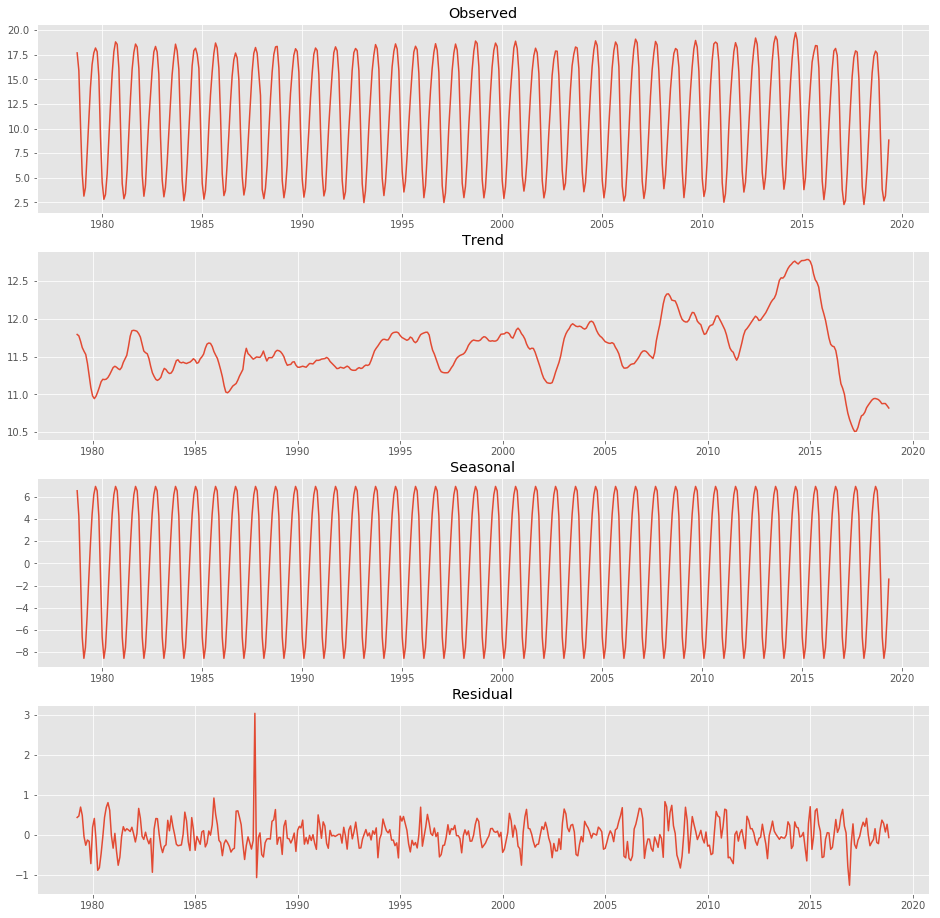

In [112]:
# Decompose the southern hemisphere ice extent time series into its trend, seasonal, and residual components
south_decomp = seasonal_decompose(south_ice_monthly.south_extent)
plot_decompose(south_decomp)

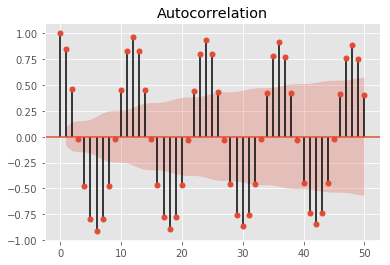

In [81]:
# Plot the autocorrelation function
plot_acf(south_ice_monthly.south_extent, lags=50);

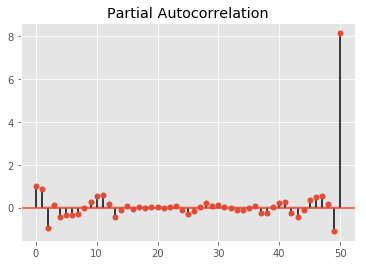

In [82]:
# Plot the partial autocorrelation function
plot_pacf(south_ice_monthly.south_extent, lags=50);

In [83]:
# Perform a grid search for the orders of a SARIMA model
south_params = grid_search_arima(range(0,3), 12, south_ice_monthly.south_extent)

In [130]:
# Obtain the orders of the model with the lowest AIC and BIC scores
print(f"Best Parameters by AIC: {south_params.loc[south_params['aic'].idxmin()]}")
print(f"Best Parameters by BIC: {south_params.loc[south_params['bic'].idxmin()]}")

Best Parameters by AIC: pdq         (1, 0, 2)
pdqs    (2, 1, 2, 12)
aic           475.958
bic           508.814
Name: 320, dtype: object
Best Parameters by BIC: pdq         (1, 0, 2)
pdqs    (0, 1, 2, 12)
aic           477.003
bic           501.645
Name: 302, dtype: object


In [84]:
# Split the data into training and testing sets
train_south = south_ice_monthly.south_extent.iloc[:-180] # 180 months = 15 years
test_south = south_ice_monthly.south_extent.iloc[-180:]

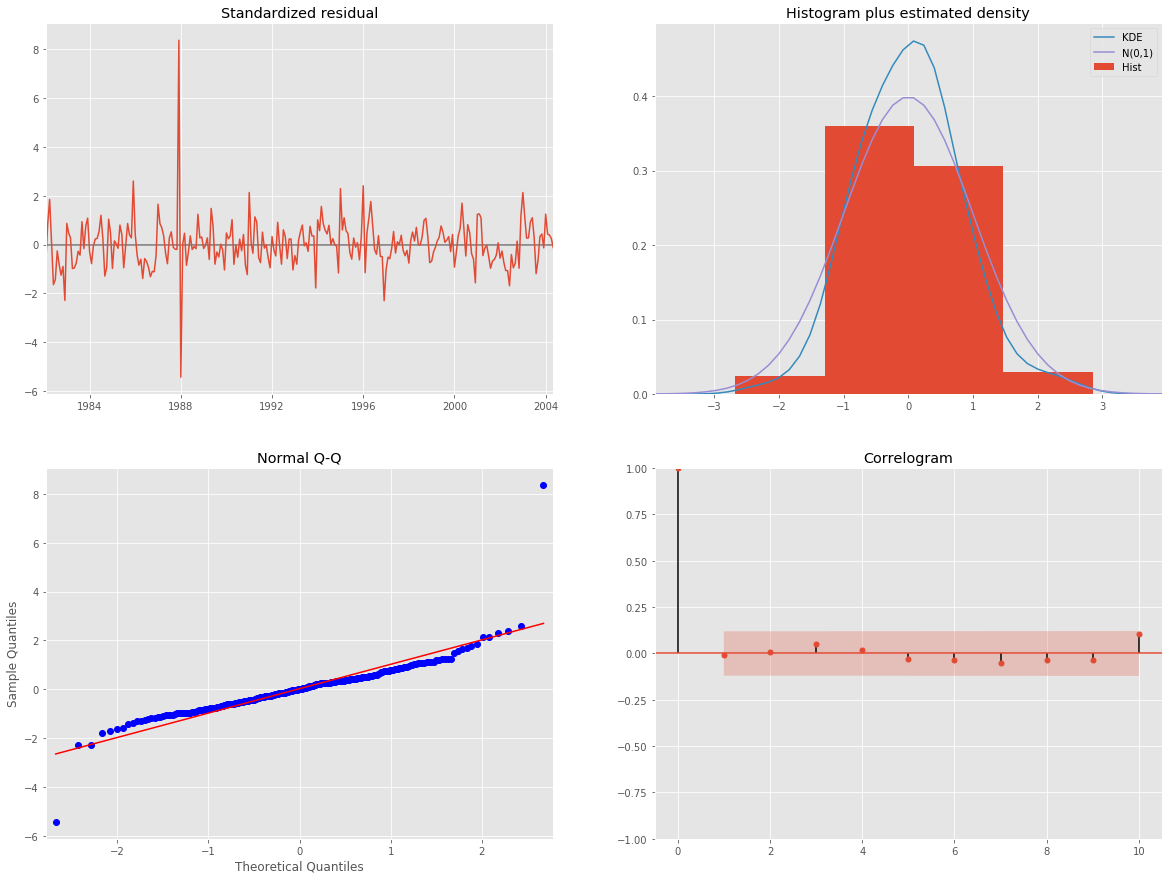

Model Performance Measures:
Root Mean Squared Error: 0.7529260612146246
R-Squared: 0.9823064030986002


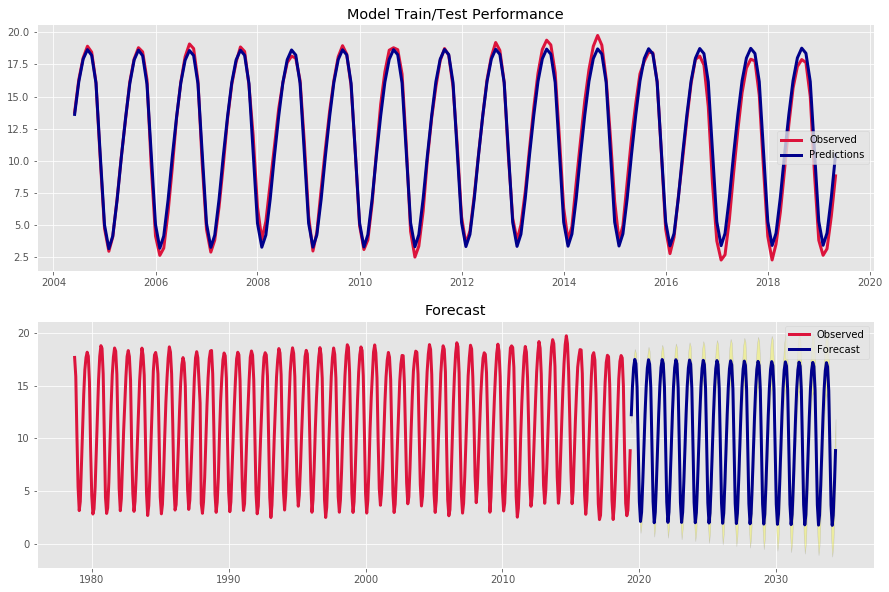

In [142]:
# Evaluate model with AIC parameters
sarimax_eval(train_south, test_south, south_ice_monthly.south_extent, 180, (1,1,2), (2,1,2,12), 'n', enforce=False)

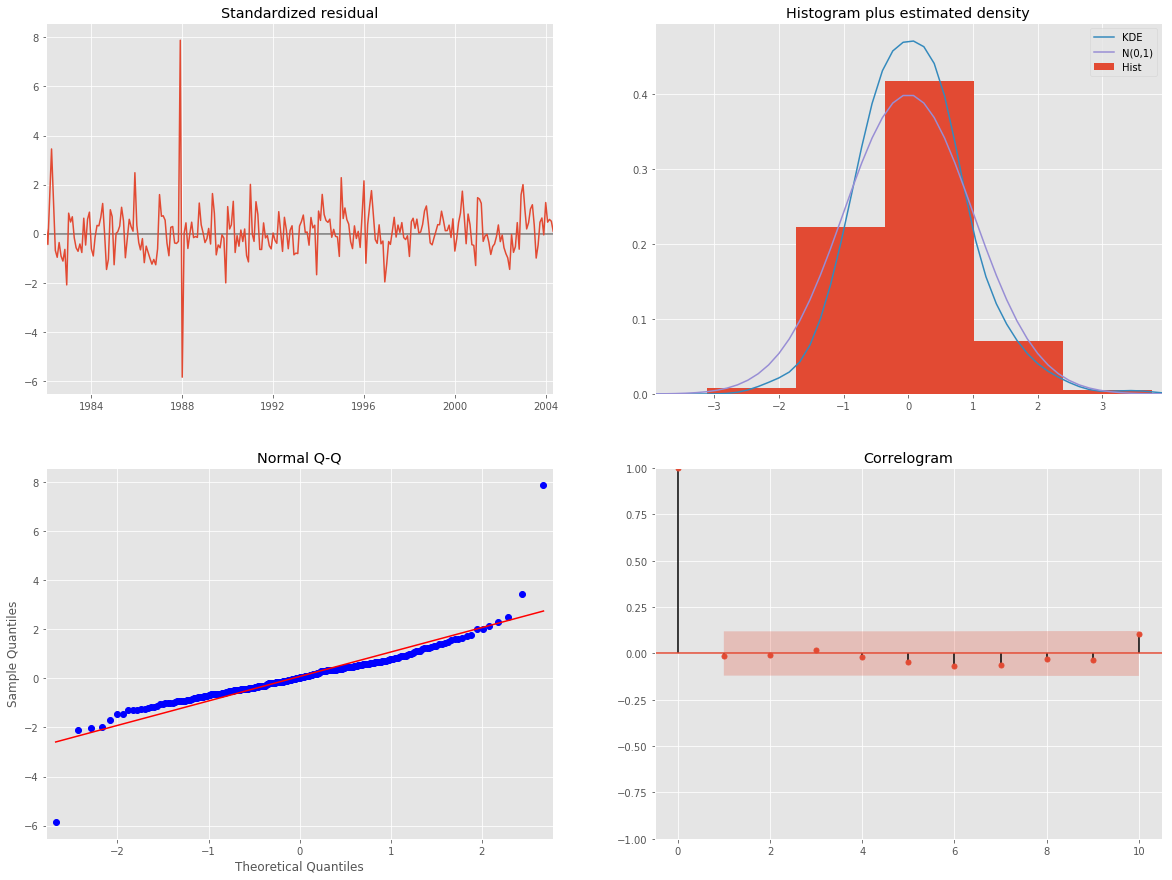

Model Performance Measures:
Root Mean Squared Error: 0.7587454458800227
R-Squared: 0.9820318376010548


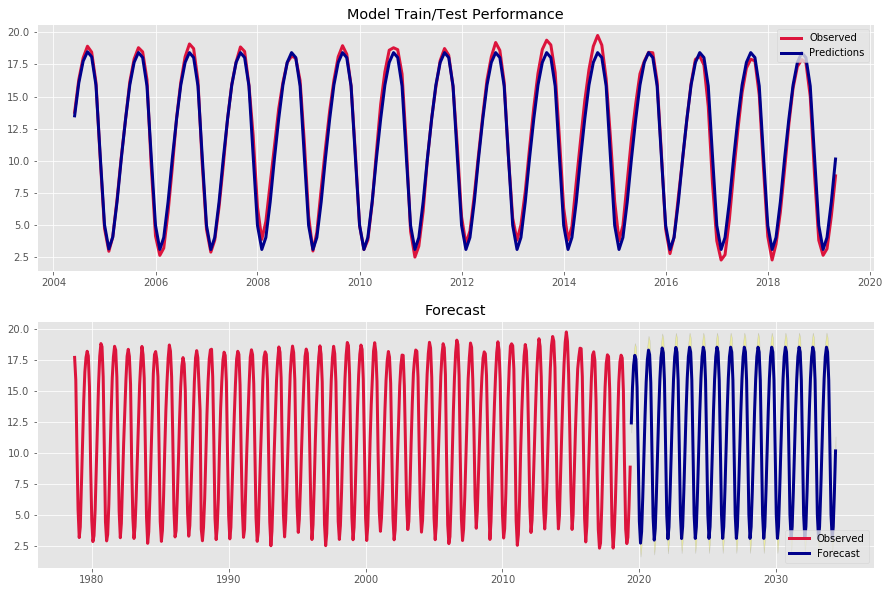

In [135]:
# Evaluate model with BIC parameters
sarimax_eval(train_south, test_south, south_ice_monthly.south_extent, 180, (1,0,2), (0,1,2,12), 'n', enforce=False)

**Analysis:** Both models satisfy the stationarity, normality, and homoskedasticity assumptions. The model using the best AIC parameters had an R-squared score of 0.9823, which is 0.0003 higher than the R-squared score for the model using the best BIC parameters. Thus, the best AIC parameters will be used to forecast the southern hemisphere ice extent values.
<br>
## Forecasted Ice Extent of the Southern Hemisphere

In [85]:
# Instantiate the final SARIMA model for southern hemisphere ice extent data and fit it to entire series
south_final = SARIMAX(south_ice_monthly.south_extent, order=(1,0,2), seasonal_order=(2,1,2,12), trend='n', 
                      enforce_stationarity=False, enforce_invertibility=False)
south_model = south_final.fit()

In [86]:
# Get forecast 600 steps (50 years) ahead in future
south_fcast = south_model.get_forecast(steps=600, dynamic=True)

# Get confidence intervals of forecasts
south_conf = south_fcast.conf_int()

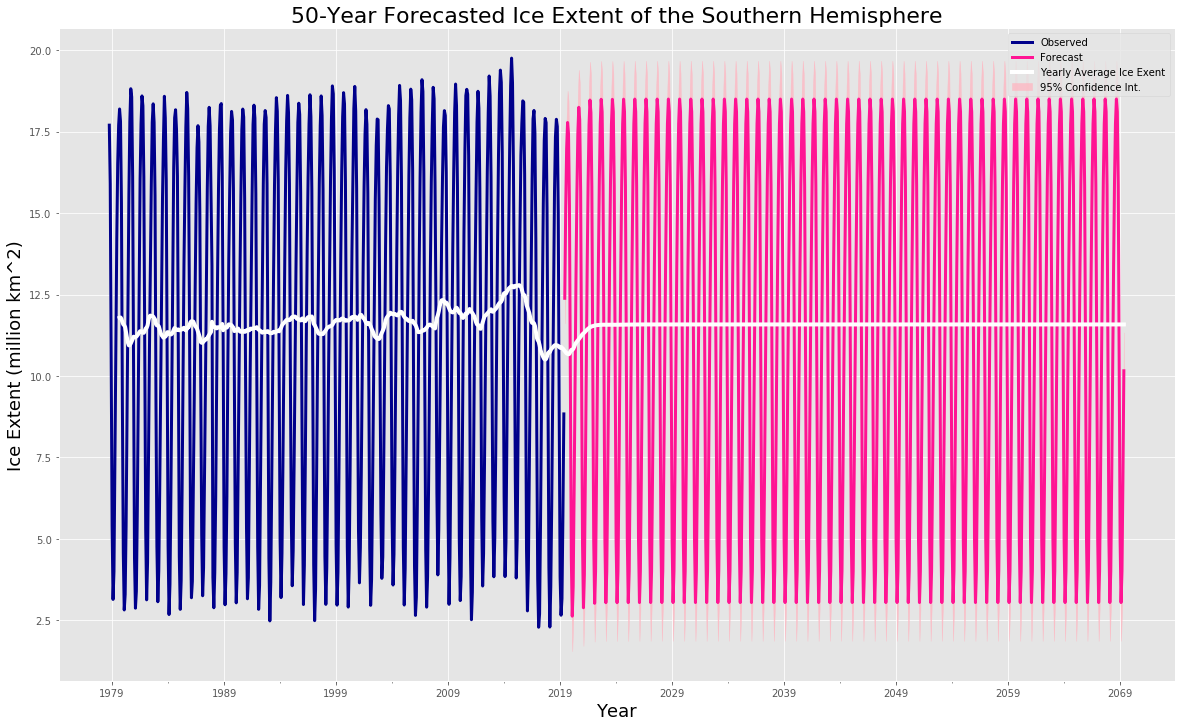

In [87]:
# Plot future predictions with confidence intervals

south_joined = pd.concat([south_ice_monthly.south_extent, south_fcast.predicted_mean], axis=0)

ax = south_ice_monthly.south_extent.plot(label='Observed', figsize=(20, 12), lw=3, color='darkblue')

south_fcast.predicted_mean.plot(ax=ax, label='Forecast', color='deeppink', lw=3)
ax.fill_between(south_conf.index,
                south_conf.iloc[:, 0],
                south_conf.iloc[:, 1], color='lightpink', alpha=.75, label='95% Confidence Int.')
ax = south_joined.rolling(window=12).mean().plot(label='Yearly Average Ice Exent', color='white', lw=4)
ax.set_xlabel('Year', fontsize=18, color='black')
ax.set_ylabel('Ice Extent (million km^2)', fontsize=18, color='black')

plt.title('50-Year Forecasted Ice Extent of the Southern Hemisphere', fontsize=22)
plt.legend()
plt.show()

**Analysis:** Based on the predictions from the model, the ice extent of the southern hemisphere is not expected to change. While this differs from what would be expected as the planet warms, it is not necessarily surprising as research has indicated that the northern hemisphere is warming to a greater degree than the southern hemisphere. Thus, the ice extent in the northern hemisphere would be expected to decrease faster than the ice in the southern hemisphere.
<br><br>

## 3. Sea Levels

In [22]:
# Remind myself what the dataframe looks like
sea_level.head()

GMSL  GMSL uncertainty
datetime                           
1880-01-01 -183.0              24.2
1880-02-01 -171.1              24.2
1880-03-01 -164.3              24.2
1880-04-01 -158.2              24.2
1880-05-01 -158.7              24.2

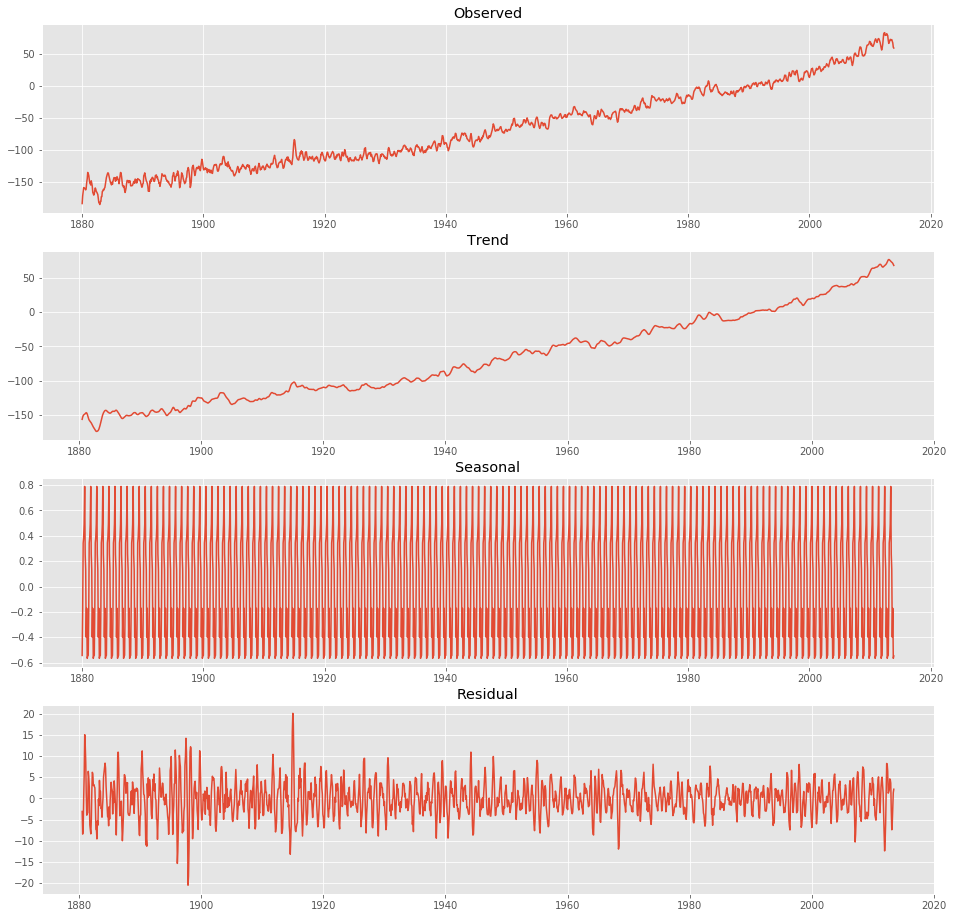

In [88]:
# Decompose the sea level time series into its trend, seasonal, and residual components
sea_decomp = seasonal_decompose(sea_level.GMSL)
plot_decompose(sea_decomp)

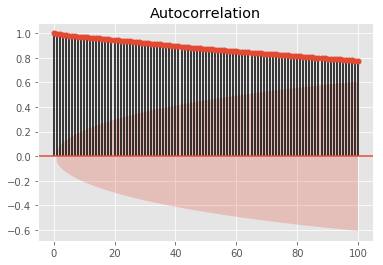

In [89]:
# Plot the autocorrelation function
plot_acf(sea_level.GMSL, lags=100);

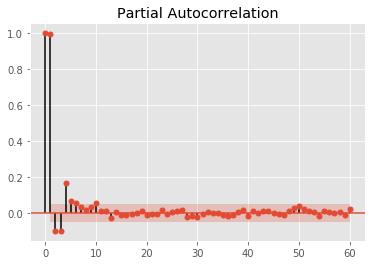

In [90]:
# Plot the partial autocorrelation function
plot_pacf(sea_level.GMSL, lags=60);

In [91]:
# Perform a grid search for the orders of a SARIMA model
sea_params = grid_search_arima(range(0,3), 12, sea_level.GMSL)

In [28]:
# Obtain the orders of the model with the lowest AIC and BIC scores
print(f"Best Parameters by AIC: {sea_params.loc[sea_params['aic'].idxmin()]}")
print(f"Best Parameters by BIC: {sea_params.loc[sea_params['bic'].idxmin()]}")

Best Parameters by AIC: pdq         (2, 0, 2)
pdqs    (2, 2, 2, 12)
aic           7131.11
bic           7179.26
Name: 566, dtype: object
Best Parameters by BIC: pdq         (1, 0, 2)
pdqs    (2, 2, 2, 12)
aic           7136.25
bic           7179.05
Name: 323, dtype: object


In [92]:
# Split the data into training and testing sets
train_sea = sea_level.GMSL.iloc[:-600] # 600 months = 50 years
test_sea = sea_level.GMSL.iloc[-600:]

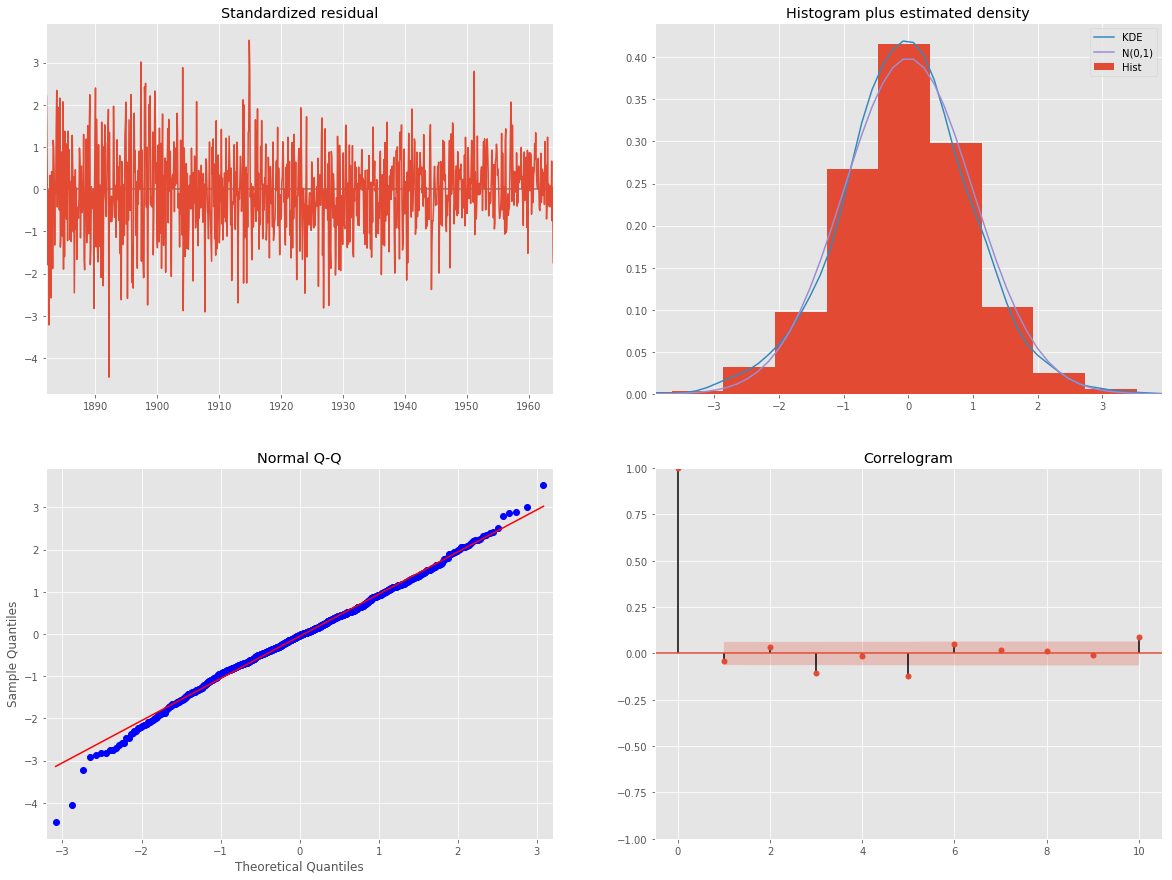

Model Performance Measures:
Root Mean Squared Error: 8.55579270194111
R-Squared: 0.9357431100773761


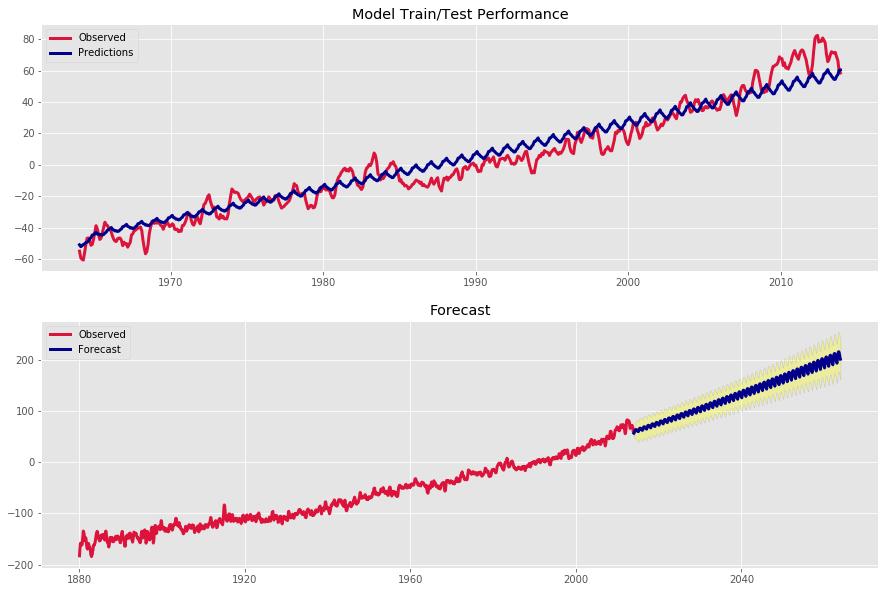

In [34]:
# Evaluate model with AIC parameters
sarimax_eval(train_sea, test_sea, sea_level.GMSL, 600, (2,0,2), (2,2,2,12), 'c', enforce=True)

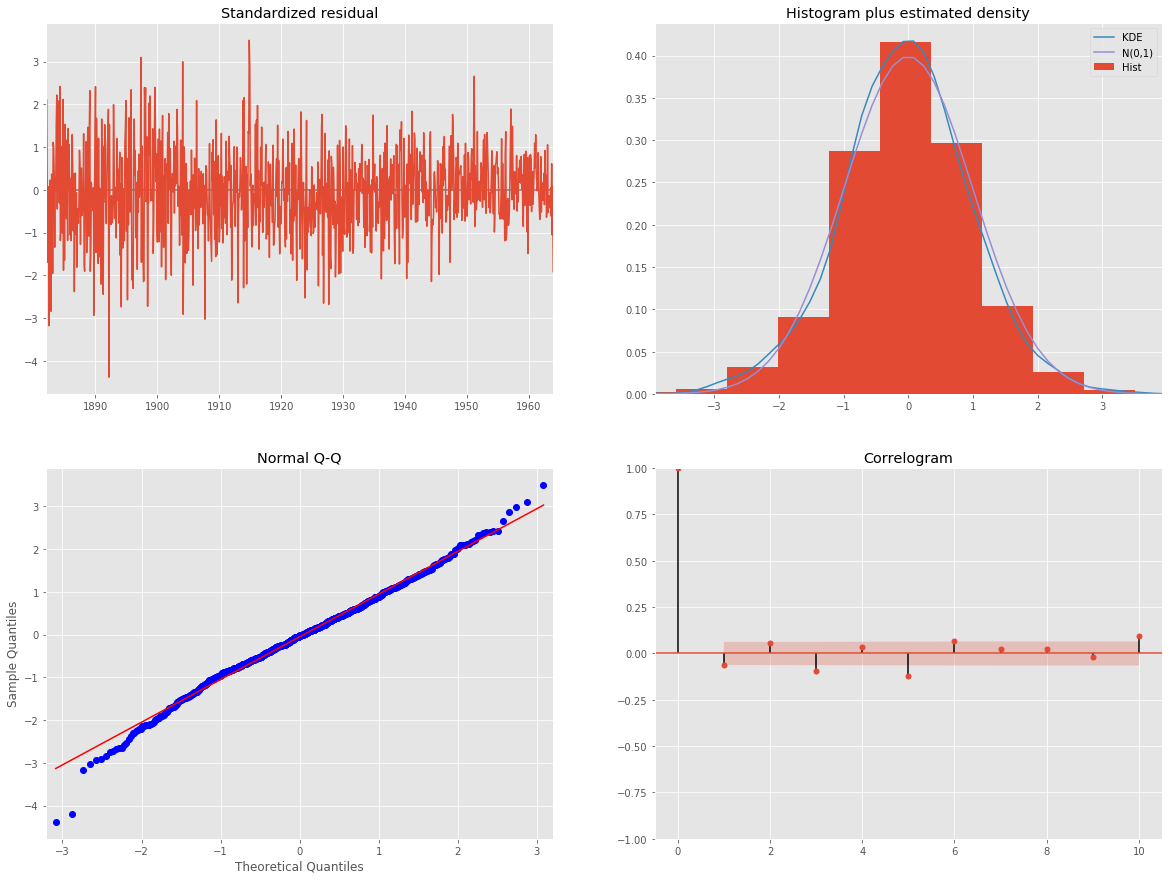

Model Performance Measures:
Root Mean Squared Error: 10.98650231811562
R-Squared: 0.8940458192278645


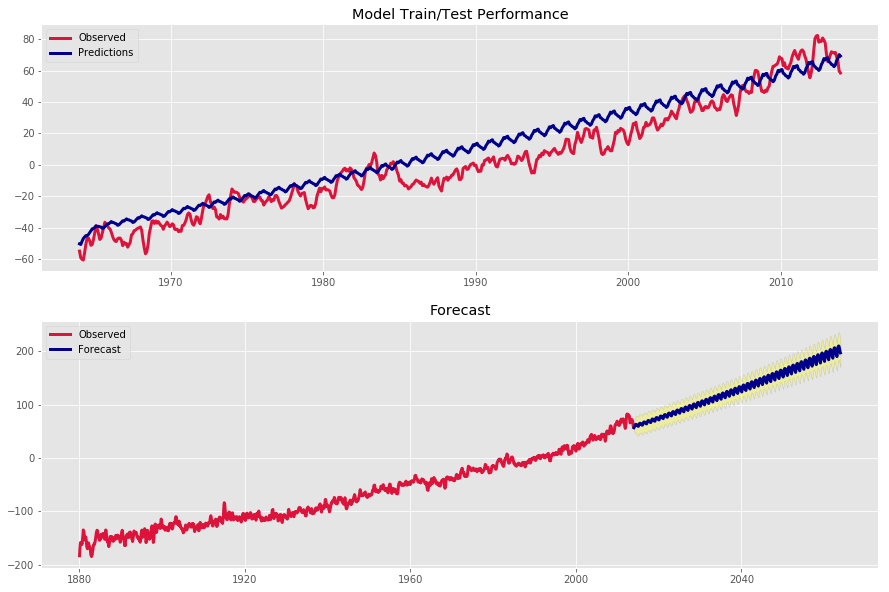

In [35]:
# Evaluate model with BIC parameters
sarimax_eval(train_sea, test_sea, sea_level.GMSL, 600, (1,0,2), (2,2,2,12), 'c', enforce=True)

**Analysis:** Both models satisfy the stationarity, normality, and homoskedasticity assumptions. The model using the parameters with the best AIC score had an R-squared value of 0.936, which is 0.042 greater than the R-squared value of the model using the best BIC parameters. Thus, the parameters from the best model based on AIC will be used to forecast predictions for sea level change.

### Forecast Sea Level Changes

In [110]:
# Instantiate the final SARIMA model for sea level change data and fit it to entire series
sea_final = SARIMAX(sea_level.GMSL, order=(2,0,2), seasonal_order=(2,2,2,12), trend='c', 
                      enforce_stationarity=True, enforce_invertibility=True)
sea_model = sea_final.fit()

In [111]:
# Get forecast 600 steps ahead in future (50 years)
sea_fcast = sea_model.get_forecast(steps=600, dynamic=True)

# Get confidence intervals of forecasts
sea_conf = sea_fcast.conf_int()

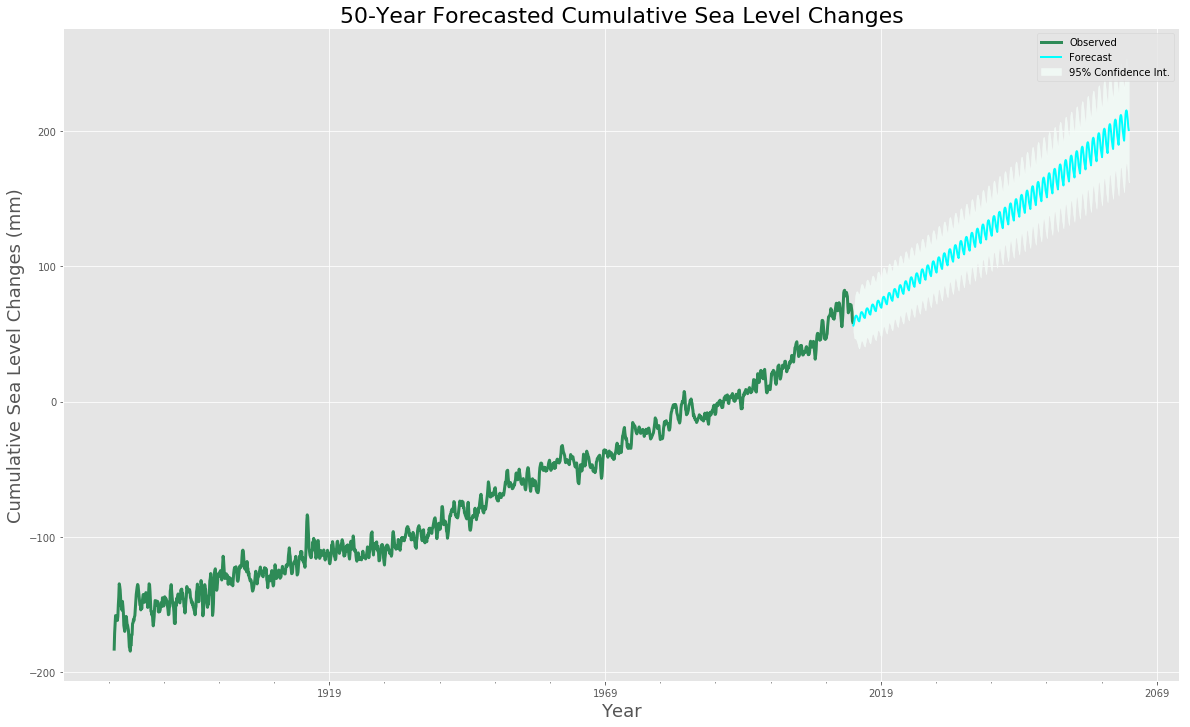

In [119]:
# Plot future predictions with confidence intervals

#sea_joined = pd.concat([sea_level.GMSL, sea_fcast.predicted_mean], axis=0)

ax = sea_level.GMSL.plot(label='Observed', figsize=(20, 12), lw=3, color='seagreen')

sea_fcast.predicted_mean.plot(ax=ax, label='Forecast', color='aqua', lw=2)
ax.fill_between(sea_conf.index,
                sea_conf.iloc[:, 0],
                sea_conf.iloc[:, 1], color='mintcream', alpha=.75, label='95% Confidence Int.')
#ax = sea_joined.rolling(window=12).mean().plot(label='Yearly Average Ice Exent', color='white', lw=3)
ax.set_xlabel('Year', fontsize=18)
ax.set_ylabel('Cumulative Sea Level Changes (mm)', fontsize=18)

plt.title('50-Year Forecasted Cumulative Sea Level Changes', fontsize=22)
plt.legend()
plt.show()

**Analysis:** The global mean sea level is predicted to continue rising at a rate of 2.8 mm per year. In fifty years, the global mean sea level is predicted to be 15 centimeters above current levels.

## 4. Greenhouse Gases
Because there is a clear exponential trend without seasonality, the Holt Winters Method will be used to model and forecast carbon dioxide and methane levels. Holt's Linear Smoothing method is preferable when the data exhibits a trend, but no seasonality. It is a window function that utilizes both a level and a trend component. For these models, the GHG concentration data will be log transformed to aid in the forecasting accuracy of the model.
    
Article outlining Holt model: https://towardsdatascience.com/time-series-in-python-exponential-smoothing-and-arima-processes-2c67f2a52788

### A. Carbon Dioxide (CO$_{2}$)

In [93]:
# Isolate carbon dioxide concentration measurements
CO2 = icecore1700[['co2_ppm']]
CO2.head()

co2_ppm
year_CE            
1700-01-01    276.6
1701-01-01    276.6
1702-01-01    276.6
1703-01-01    276.6
1704-01-01    276.6

In [94]:
# Calculate the log values of the concentration measurements for modeling
CO2['log_co2'] = np.log(CO2.co2_ppm)
CO2.head()

co2_ppm   log_co2
year_CE                      
1700-01-01    276.6  5.622572
1701-01-01    276.6  5.622572
1702-01-01    276.6  5.622572
1703-01-01    276.6  5.622572
1704-01-01    276.6  5.622572

In [95]:
# Split the data into training and testing sets
train_co2 = CO2.log_co2.iloc[:-30] # 30 years
test_co2 = CO2.log_co2.iloc[-30:]

In [96]:
# Create a Holt model and fit it to the training set
co2_holt = Holt(train_co2, exponential=True)
co2_holt_model = co2_holt.fit(optimized=True)

In [97]:
# Evaluate the model on the testing set

start = len(train_co2)
end = len(train_co2)+len(test_co2)-1

# generate predictions
co2_holt_preds = co2_holt_model.predict(start=start, end=end)

# Calculate the root mean squared error and r-squared scores
co2_rmse2 = rmse(test_co2, co2_holt_preds)
print(f"Root Mean Squared Error: {co2_rmse2}")
print('Standard deviation of test set:', test_co2.std())
co2_r2 = r2_score(test_co2, co2_holt_preds)
print(f"R-Squared: {co2_r2}")

Root Mean Squared Error: 0.008881423646072688
Standard deviation of test set: 0.038538212714851035
R-Squared: 0.9450578954773309


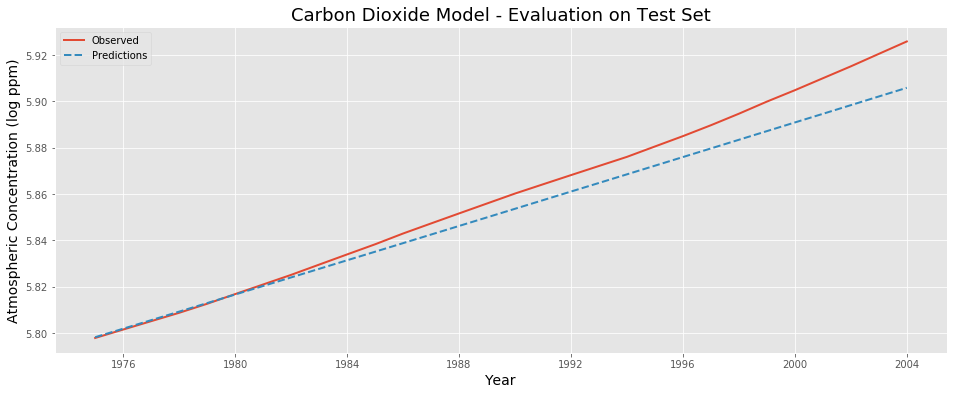

In [99]:
# Plot the testing set and the predictions
fig=plt.figure(figsize=(16,6))
plt.plot(test_co2, label='Observed',lw=2)
plt.plot(co2_holt_preds, label='Predictions',ls="--", lw=2)
plt.xlabel('Year', fontsize=14, color='black')
plt.ylabel('Atmospheric Concentration (log ppm)', fontsize=14, color='black')
plt.title('Carbon Dioxide Model - Evaluation on Test Set', fontsize=18)
plt.legend()
plt.show()

**Analysis:** The Holt model for carbon dioxide concentration had an R-squared score of 0.945 when evaluated on the testing set and the root mean squared error of its predictions were less than the standard deviation of the testing set. These measures indicate that the model performs with roughly 94.5% accuracy and should provide reasonable predictions for future carbon dioxide concentration values. However, based on the model's performance on the testing set, the forecasted carbon dioxide concentration values may be lower than the actual values as the model seemed to consistently predict values lower than the testing set.

In [100]:
# Instantiate the final Holt model for carbon dioxide data and fit it to entire series
co2_holt_final = Holt(CO2.log_co2, exponential=True)
co2_holt_model_final = co2_holt_final.fit(optimized=True)

In [101]:
# To inverse transform the predictions
import math

# Function to inverse the log transformation of the data
def inverse_ln (val):
    inv_ln = math.exp(val)
    return inv_ln

# Get forecast 50 steps ahead in future (50 years)
co2_fcast = co2_holt_model_final.predict(start=len(CO2), end=len(CO2)+50)

# Inverse transform the predictions 
un_log_co2_fcast = co2_fcast.map(inverse_ln)

joined_co2 = CO2.co2_ppm.append(un_log_co2_fcast)

# # Get confidence intervals of forecasts
# co2_conf = co2_fcast.conf_int()

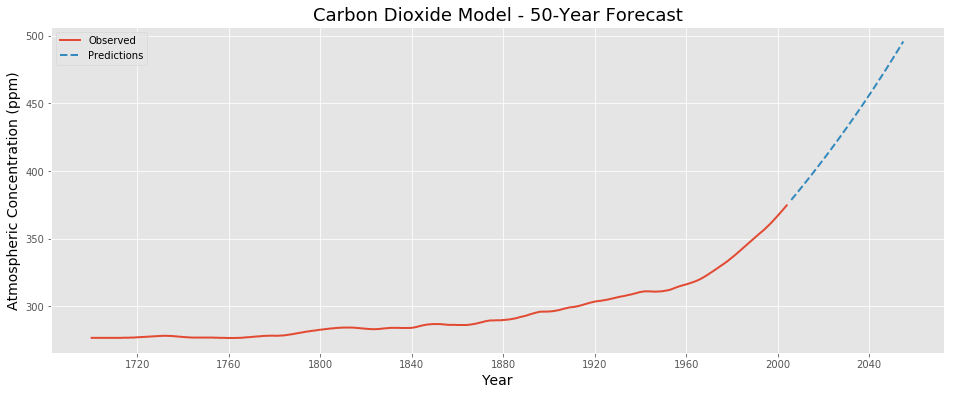

In [102]:
# Plot forecasted results with observed carbon dioxide measurements
fig=plt.figure(figsize=(16,6))
plt.plot(joined_co2.iloc[:305], label='Observed',lw=2)
plt.plot(joined_co2.iloc[-50:], label='Predictions',ls="--", lw=2)
plt.xlabel('Year', fontsize=14, color='black')
plt.ylabel('Atmospheric Concentration (ppm)', fontsize=14, color='black')
plt.title('Carbon Dioxide Model - 50-Year Forecast', fontsize=18)
plt.legend()
plt.show()

**Analysis:** The model predicts that the atmospheric carbon dioxide concentration will continue rising and it is expected to reach the critical value of 450 ppm by 2038. However, as the model tended to predict values lower than the observed measures when evaluated on the testing set, the 450 ppm concentration may be reached sooner than 2038.

### B. Methane (CH$_{4}$)

In [103]:
# Isolate methane concentration measurements
CH4 = icecore1700[['ch4_ppb']]
CH4['log_ch4'] = np.log(CH4.ch4_ppb)
CH4.head()

ch4_ppb   log_ch4
year_CE                      
1700-01-01    669.2  6.506083
1701-01-01    667.9  6.504138
1702-01-01    666.7  6.502340
1703-01-01    665.6  6.500689
1704-01-01    664.6  6.499185

In [104]:
# Split the data into training and testing sets
train_ch4 = CH4.log_ch4.iloc[:-50] # 50 years
test_ch4 = CH4.log_ch4.iloc[-50:]

In [105]:
# Create a Holt model and fit it to the training set
ch4_holt = Holt(train_ch4, exponential=True, damped=True)
ch4_holt_model = ch4_holt.fit(optimized=True)

# Generate predictions
start = len(train_ch4)
end = len(train_ch4)+len(test_ch4)-1
ch4_holt_preds = ch4_holt_model.predict(start=start, end=end)

# Evaluate model performance on the testing set
ch4_rmse2 = rmse(test_ch4, ch4_holt_preds)
print(f"Root Mean Squared Error: {ch4_rmse2}")
print('Standard deviation of test set:', test_ch4.std())
ch4_r2 = r2_score(test_ch4, ch4_holt_preds)
print(f"R-Squared: {ch4_r2}")

Root Mean Squared Error: 0.0267245241804755
Standard deviation of test set: 0.13167077041143896
R-Squared: 0.9579646048780217


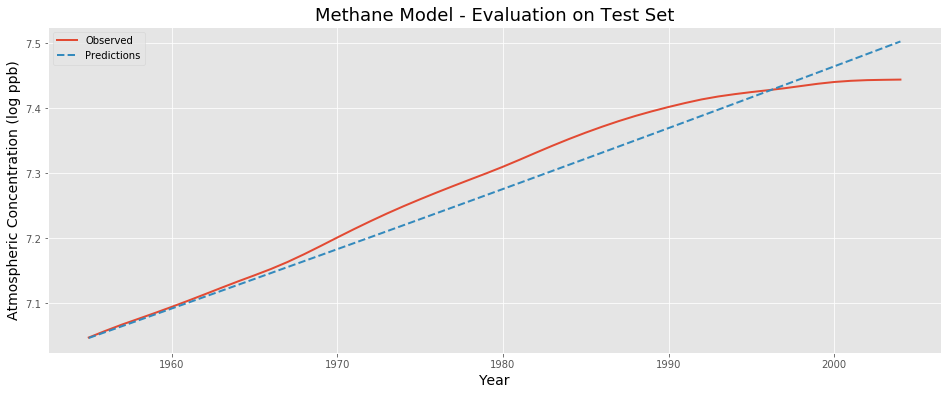

In [106]:
# Plot the testing set and the predictions 
fig=plt.figure(figsize=(16,6))
plt.plot(test_ch4, label='Observed',lw=2)
plt.plot(ch4_holt_preds, label='Predictions',ls="--", lw=2)
plt.xlabel('Year', fontsize=14, color='black')
plt.ylabel('Atmospheric Concentration (log ppb)', fontsize=14, color='black')
plt.title('Methane Model - Evaluation on Test Set', fontsize=18)
plt.legend()
plt.show()

**Analysis:** The Holt model for methane concentration had an R-squared score of 0.958 when evaluated on the testing set and the root mean squared error of its predictions were less than the standard deviation of the testing set. These measures indicate that the model performs with roughly 95.7% accuracy and should provide reasonable predictions for future methane concentration values. However, based on the model's performance on the testing set, the forecasted methane concentration values may be higher than the actual values as the model seemed to predict a constant increase in the values, whereas the values of the last 15 years in the testing set seem to show the concentration beginning to level off.

In [107]:
# Instantiate the final Holt model for methane data and fit it to entire series
ch4_holt_final = Holt(CH4.log_ch4, exponential=True, damped=True)
ch4_holt_model_final = ch4_holt_final.fit(optimized=True)

In [108]:
# Get forecast 50 steps ahead in future (50 years)
ch4_fcast = ch4_holt_model_final.predict(start=len(CH4), end=len(CH4)+50)

#co2_fcast.head()
un_log_ch4_fcast = ch4_fcast.map(inverse_ln)

joined_ch4 = CH4.ch4_ppb.append(un_log_ch4_fcast)

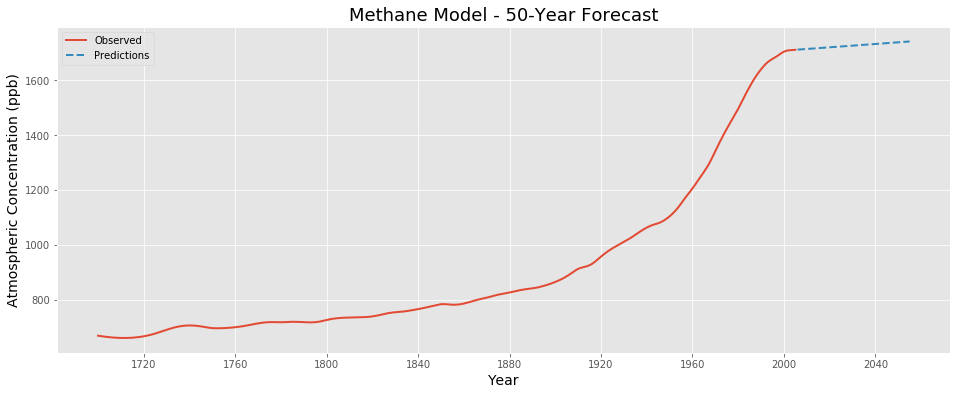

In [109]:
# Plot forecasted values with observed methane measurements
fig=plt.figure(figsize=(16,6))
plt.plot(joined_ch4.iloc[:-50], label='Observed',lw=2)
plt.plot(joined_ch4.iloc[-50:], label='Predictions',ls="--", lw=2)
plt.xlabel('Year', fontsize=14, color='black')
plt.ylabel('Atmospheric Concentration (ppb)', fontsize=14, color='black')
plt.title('Methane Model - 50-Year Forecast', fontsize=18)
plt.legend()
plt.show()

**Analysis:** The model predicts that the atmospheric concentration of methane will continue to rise, but at a much slower rate than carbon dioxide. However, as the model tended to predict values greater than the observed measures in the testing set, the actual rate of increase may actually be lower than predicted.
